In [1]:
import pandas as pd
import numpy as np
import math
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
from collections import Counter

In [6]:
# format plots for Latex
font = {"family": "Times New Roman", "size": 18}
plt.rc("font", **font)

# Read data, explore target

In [3]:
data = pd.read_excel("220626_chocolate_bar_rating.xlsx")
data.columns = [
    "ref",
    "company_manufacturer",
    "company_location",
    "review_date",
    "country_of_bean_origin",
    "specific_bean_origin_or_bar_name",
    "cocoa_percent",
    "ingredients",
    "most_memorable_characteristics",
    "rating",
]
# data = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2022/2022-01-18/chocolate.csv")
data

,ref,company_manufacturer,company_location,review_date,country_of_bean_origin,specific_bean_origin_or_bar_name,cocoa_percent,ingredients,most_memorable_characteristics,rating
0,2454,5150,U.S.A.,2019,Tanzania,"Kokoa Kamili, batch 1",76%,"3- B,S,C","rich cocoa, fatty, bready",3.25
1,2454,5150,U.S.A.,2019,Madagascar,"Bejofo Estate, batch 1",76%,"3- B,S,C","cocoa, blackberry, full body",3.75
2,2458,5150,U.S.A.,2019,Dominican Republic,"Zorzal, batch 1",76%,"3- B,S,C","cocoa, vegetal, savory",3.50
3,2542,5150,U.S.A.,2021,Fiji,"Matasawalevu, batch 1",68%,"3- B,S,C","chewy, off, rubbery",3.00
4,2542,5150,U.S.A.,2021,India,"Anamalai, batch 1",68%,"3- B,S,C","milk brownie, macadamia,chewy",3.50
...,...,...,...,...,...,...,...,...,...,...
2583,1205,Zotter,Austria,2014,Blend,Raw,80%,"4- B,S*,C,Sa","waxy, cloying, vegetal",2.75
2584,1996,Zotter,Austria,2017,Colombia,"APROCAFA, Acandi",75%,"3- B,S,C","strong nutty, marshmallow",3.75
2585,2036,Zotter,Austria,2018,Blend,"Dry Aged, 30 yr Anniversary bar",75%,"3- B,S,C","fatty, earthy, cocoa",3.00
2586,2170,Zotter,Austria,2018,Congo,Mountains of the Moon,70%,"3- B,S,C","fatty, mild nuts, mild fruit",3.25


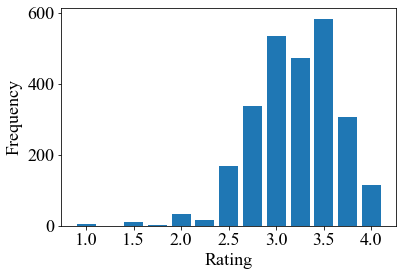

In [7]:
rating_counts = data["rating"].value_counts()
plt.bar(rating_counts.index, rating_counts, width=0.2)
plt.xticks(np.arange(1,4.5,0.5))
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.savefig("figures/ratings_hist.pdf", bbox_inches="tight")
plt.show()

# Data exploration

In [7]:
categorical_features = [
    "company_manufacturer",
    "company_location",
    "review_date",
    "country_of_bean_origin",
    "specific_bean_origin_or_bar_name",
    "ingredients",
    "most_memorable_characteristics",
]

pd.DataFrame(
    {
        "categories": data.loc[:, categorical_features].apply(
            lambda x: len(x.unique())
        ),
        "only occurs once": [
            sum(data.loc[:, col].value_counts() == 1) for col in categorical_features
        ],
    }
)

,categories,only occurs once
company_manufacturer,593,155
company_location,65,5
review_date,17,0
country_of_bean_origin,63,11
specific_bean_origin_or_bar_name,1643,1423
ingredients,22,3
most_memorable_characteristics,2545,2511


## Company Manufacturer

In [8]:
manufacturer_shares = data["company_manufacturer"].value_counts() / len(data)
manufacturer_shares#.iloc[0:65,]

Soma                                  0.022025
Fresco                                0.015070
Arete                                 0.012365
Bonnat                                0.011592
A. Morin                              0.011206
                                        ...   
Rococo (Grenada Chocolate Co.)        0.000386
Cacao Arabuco                         0.000386
Britarev                              0.000386
Love Bar                              0.000386
Chocolates by Josh (Box Chocolate)    0.000386
Name: company_manufacturer, Length: 593, dtype: float64

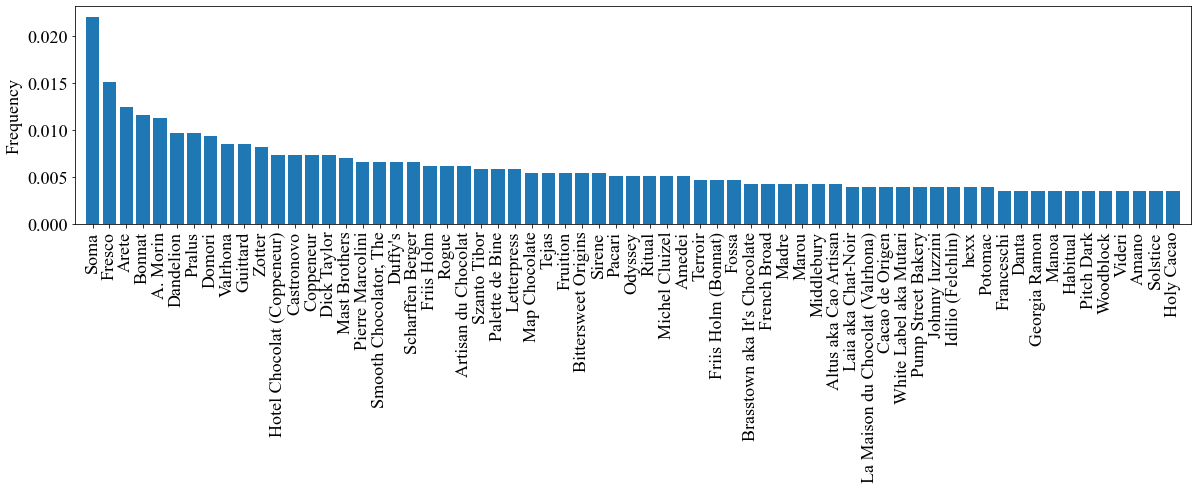

In [9]:
shares = manufacturer_shares.iloc[0:65]
fig, ax = plt.subplots(figsize=(20, 4))
bars = ax.bar(shares.index, shares)

plt.margins(0.01, 0.05)
plt.xticks(rotation=90)
plt.ylabel("Frequency")
plt.savefig("figures/company_manufacturer_barplot.pdf", bbox_inches="tight")
plt.show()

## Company Location

In [10]:
location_shares = data["company_location"].value_counts() / len(data)
location_shares

U.S.A.                   0.451314
France                   0.069165
Canada                   0.068779
U.K.                     0.051777
Italy                    0.030526
                           ...   
St.Vincent-Grenadines    0.000386
Wales                    0.000386
Martinique               0.000386
Ghana                    0.000386
Suriname                 0.000386
Name: company_location, Length: 65, dtype: float64

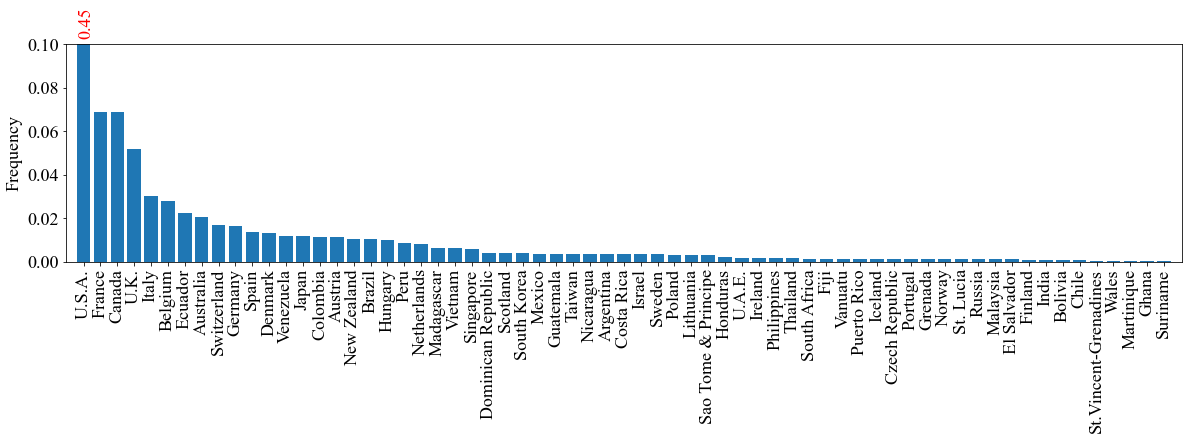

In [11]:
fig, ax = plt.subplots(figsize=(20, 4))
bars = ax.bar(location_shares.index, location_shares)
ax.set_ylim(0, 0.1)

h_usa = f"{round(bars[0].get_height(),2)}"
ax.text(
    bars[0].get_x() + 0.1, 0.11, s=h_usa, ha="left", va="center", rotation=90, c="red"
)

plt.margins(0.01, 0.05)
plt.xticks(rotation=90)
plt.ylabel("Frequency")
plt.savefig("figures/company_location_barplot.pdf", bbox_inches="tight")
plt.show()

In [12]:
# number of company locations that make up 80% of the observations
len(location_shares.loc[location_shares.cumsum() <= 0.8].index)

11

## Review Date

In [13]:
date_freq = data["review_date"].value_counts().sort_index()

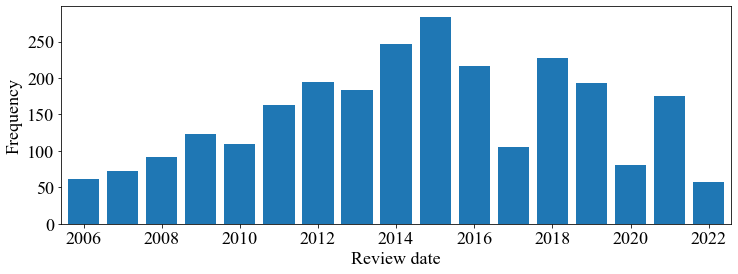

In [14]:
fig, ax = plt.subplots(figsize=(12, 4))
bars = ax.bar(date_freq.index, date_freq)

plt.margins(0.01, 0.05)
plt.xlabel("Review date")
plt.ylabel("Frequency")
plt.show()

## Country of Bean Origin

In [15]:
origin_shares = data["country_of_bean_origin"].value_counts() / len(data)
origin_shares

Venezuela             0.098145
Peru                  0.095827
Dominican Republic    0.090417
Ecuador               0.086167
Madagascar            0.071097
                        ...   
China                 0.000386
Principe              0.000386
Sulawesi              0.000386
Suriname              0.000386
DR Congo              0.000386
Name: country_of_bean_origin, Length: 63, dtype: float64

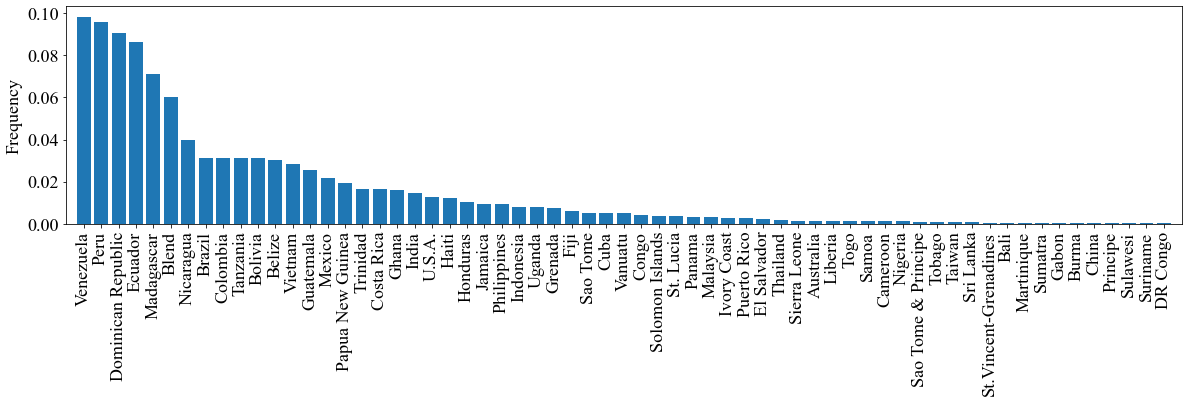

In [16]:
fig, ax = plt.subplots(figsize=(20, 4))
bars = ax.bar(origin_shares.index, origin_shares)

plt.margins(0.01, 0.05)
plt.xticks(rotation=90)
plt.ylabel("Frequency")
plt.savefig("figures/bean_origin_barplot.pdf", bbox_inches="tight")
plt.show()

## Cocoa Percent

In [17]:
cocoa_percent = data.loc[:, "cocoa_percent"].apply(lambda x: float(x[:-1]))
print(cocoa_percent.min())
print(cocoa_percent.max())

42.0
100.0


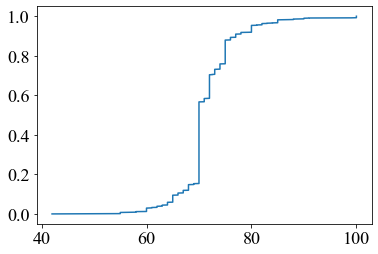

In [18]:
ecdf_percent = ECDF(cocoa_percent)
plt.plot(ecdf_percent.x, ecdf_percent.y)

## Most Memorable Characteristics

In [19]:
data["most_memorable_characteristics"]

0           rich cocoa, fatty, bready
1        cocoa, blackberry, full body
2              cocoa, vegetal, savory
3                 chewy, off, rubbery
4       milk brownie, macadamia,chewy
                    ...              
2583           waxy, cloying, vegetal
2584        strong nutty, marshmallow
2585             fatty, earthy, cocoa
2586     fatty, mild nuts, mild fruit
2587        muted, roasty, accessible
Name: most_memorable_characteristics, Length: 2588, dtype: object

In [20]:
flavors = (
    data["most_memorable_characteristics"]
    .str.replace(" and", ",")
    .str.split(",\s*|\s", expand=True)
)

flavors_list = []
for i in range(5):
    flavors_list.extend(flavors.iloc[:, i].unique())

flavors_set = set(flavors_list)
for s in ["", None]:
    flavors_set.remove(s)

In [21]:
dupes = [x for x in flavors_list if not x in ["", None]]
for i in range(6):
    print("occur >= " + str(i + 1) + "x:", len(set(dupes)))
    seen = set()
    dupes = [x for x in dupes if x in seen or seen.add(x)]
    if i == 3:
        print(dupes)

occur >= 1x: 578
occur >= 2x: 308
occur >= 3x: 218
occur >= 4x: 135
['fatty', 'nutty', 'fruit', 'banana', 'earthy', 'sandy', 'sour', 'rubber', 'roasty', 'musty', 'cocoa', 'mint', 'creamy', 'notes', 'tart', 'vanilla', 'leather', 'coffee', 'roast', 'brownie', 'anise', 'sweet', 'off', 'berry', 'base', 'dried', 'sticky', 'floral', 'butter', 'licorice', 'nuts', 'burnt', 'spice', 'citrus', 'woody', 'molasses', 'strawberry', 'melon', 'nut', 'intense', 'rich', 'orange', 'choco', 'rubbery', 'lemon', 'smoke', 'ashey', 'harsh', 'spicy', 'grits', 'bitter', 'grassy', 'vegetal']
occur >= 5x: 53
occur >= 6x: 0


In [22]:
flavors_df = pd.Series(flavors_list).dropna()
flavors_df[flavors_df.str.contains("nut")].unique()

array(['nutty', 'nut', 'nuts', 'nutmeg', 'hazelnut', 'peanut', 'coconut',
       'cocounut', 'walnut', 'walnuts', 'peanutbutter', 'nutella'],
      dtype=object)

In [23]:
flavors_df = pd.Series(flavors_list).dropna()
flavors_df[flavors_df.str.contains("choc")].unique()

array(['chocolate', 'choco', 'chocolatey', 'chocolaty'], dtype=object)

### Autocorrect

In [1]:
from autocorrect import Speller
from spellchecker import SpellChecker

In [24]:
spell = Speller()
for f in flavors_set:
    f_corr = spell(f)
    if f != f_corr:
        print(f, "->", f_corr)

mocha -> mecha
rubbery -> rubber
bready -> ready
prunes -> runes
spiciness -> sickness
chalky -> chalk
raisiny -> raising
choco -> coco
fudge-like -> judge-like
unripe -> unlike
burlap -> burial
spciy -> spicy
walnuts -> walnut
papaya -> papal
intens -> intent
rancid -> rcid
chocolaty -> chocolate
earthy -> earth
tangy -> tango
ashey -> ashes
sugary -> sugar
raisins -> raising
powdery -> powder
pungent -> urgent
sourness -> sources
roaste -> roasted
roaster -> roster
minty -> mint
smokey -> smoke
earty -> party
nibby -> lobby
unrecognizable -> recognizable
charred -> charged
descript -> script
cheesey -> cheese
roasty -> roast
carame -> came
leathery -> leather
nibs -> nis
raisin -> raising
licoric -> iconic
undertone -> undergone
astringnet -> stringent
plums -> plus
smomkey -> smoke
pastey -> paste
lavendar -> lavender
toffee -> coffee
petro -> metro
klingy -> king
sligt -> slight
grainy -> grain
roasty/smokey -> roast/smoke
prononced -> pronounced
punchy -> punch
cooa -> cool
tolera

In [33]:
spell = SpellChecker()
for f in flavors_set:
    f_corr = spell.correction(f)
    if f != f_corr:
        print(f, "->", f_corr)

mouthfeel -> mouthful
descript -> describe
alkalyzed -> analyzed
roaste -> roast
sliglty -> slighty
Roasty -> roast
winey -> wine
unfixable -> unlikable
alocohol -> alcohol
dirt/ -> dirty
astringcy -> stringy
carame -> caramel
"Andes" -> andes
(fig) -> fig
raisns -> rains
sl. -> sly
ham-like -> hairlike
sl -> so
sligthly -> slightly
licoric -> licorice
astingent -> astringent
overyly -> overly
spicey -> spice
vanila -> vanilla
non-descript -> nondescript
prononced -> pronounced
hebs -> he's
earty -> party
astringency -> stringency
molassses -> molasses
cheesey -> cheese
cardamon -> cardamom
roasty -> roast
ligt -> light
rasin -> rain
smomkey -> smokey
nibby -> dibby
mildy -> mild
klingy -> clingy
XL -> al
pomegrant -> pomegranate
cocounut -> coconut
cinamon -> cinnamon
"rolo" -> prolon
pastey -> pastry
dutched? -> ditched
sticy -> stick
lavendar -> lavender
malitol -> marital
fertilzer -> fertilizer
accesible -> accessible
brownine -> brownie
blackcherry -> blackberry
smoth -> smooth
d

In [34]:
spell.unknown(flavors_set)

{'"andes"',
 '"rolo"',
 '(fig)',
 'accesible',
 'aftertaste',
 'alkalyzed',
 'alocohol',
 'ashey',
 'astingent',
 'astringcy',
 'astringency',
 'astringnet',
 'blackcherry',
 'blackpepper',
 'bready',
 'brownine',
 'cadbury',
 'candy-like',
 'carame',
 'cardamon',
 'cheesey',
 'cinamon',
 'cocounut',
 'cooa',
 'descript',
 'dirt/',
 'dirty/burnt',
 'distinquished',
 'domintates',
 'dutched?',
 'earty',
 'fertilzer',
 'floral-spice',
 'fudge-like',
 'ham-like',
 'hebs',
 'intens',
 'klingy',
 'lavendar',
 'licoric',
 'ligt',
 'malitol',
 'mildy',
 'molassses',
 'mouthfeel',
 'nibby',
 'non-descript',
 'overyly',
 'pastey',
 'peanutbutter',
 'pomegrant',
 'prononced',
 'raisiny',
 'raisns',
 'rasin',
 'roaste',
 'roasty',
 'roasty/smokey',
 'sl',
 'sl.',
 'sliglty',
 'sligt',
 'sligthly',
 'smomkey',
 'smoth',
 'spciy',
 'spice/herb',
 'spicey',
 'sticy',
 'sublte',
 'tea-like',
 'trop.',
 'unfixable',
 'vanila',
 'vanilla(n)',
 'w/',
 'winey',
 'woody/green',
 'wtf',
 'xl'}

In [35]:
from textblob import Word

In [36]:
for f in flavors_set:
    word = Word(f)
    print(f)
    print(word.spellcheck())

medley
[('merely', 0.9043062200956937), ('madly', 0.03349282296650718), ('meddle', 0.028708133971291867), ('motley', 0.014354066985645933), ('morley', 0.004784688995215311), ('mele', 0.004784688995215311), ('meddler', 0.004784688995215311), ('eley', 0.004784688995215311)]
mouthfeel
[('mouthfeel', 0.0)]
ending
[('ending', 1.0)]
floral
[('flora', 1.0)]
uncontrolled
[('uncontrolled', 1.0)]
is
[('is', 1.0)]
walnut
[('walnut', 1.0)]
dirty/burnt
[('dirty/burnt', 0.0)]
leather
[('leather', 1.0)]
earthy
[('earthy', 1.0)]
descript
[('rescript', 1.0)]
watery
[('watery', 1.0)]
pungent
[('pungent', 1.0)]
acidity
[('aridity', 1.0)]
well
[('well', 1.0)]
atypical
[('typical', 1.0)]
slow
[('slow', 1.0)]
oranges
[('oranges', 1.0)]
multiple
[('multiple', 1.0)]
some
[('some', 1.0)]
brown
[('brown', 1.0)]
leathery
[('leathery', 1.0)]
ripe
[('ripe', 1.0)]
alkalyzed
[('analyzed', 1.0)]
fudge
[('judge', 0.9375), ('budge', 0.0625)]
butt
[('butt', 1.0)]
roaste
[('roast', 0.8), ('roasted', 0.2)]
mild
[('mild', 

[('Fruit', 0.2702702702702703), ('Purity', 0.24324324324324326), ('Fruits', 0.1891891891891892), ('Bruit', 0.13513513513513514), ('Rusty', 0.05405405405405406), ('Equity', 0.05405405405405406), ('Trusty', 0.04054054054054054), ('Crusty', 0.013513513513513514)]
herbal
[('verbal', 1.0)]
residue
[('residue', 1.0)]
baked
[('baked', 1.0)]
mix
[('mix', 1.0)]
basic
[('basic', 1.0)]
metal
[('metal', 1.0)]
cacao
[('canal', 0.7422680412371134), ('sacro', 0.05154639175257732), ('cargo', 0.05154639175257732), ('cava', 0.030927835051546393), ('facto', 0.020618556701030927), ('carlo', 0.020618556701030927), ('cameo', 0.020618556701030927), ('cabal', 0.020618556701030927), ('cocoa', 0.010309278350515464), ('cavae', 0.010309278350515464), ('campo', 0.010309278350515464), ('cairo', 0.010309278350515464)]
gateway
[('gateway', 1.0)]
pistachio
[('pistachio', 0.0)]
bar
[('bar', 1.0)]
fat
[('fat', 1.0)]
macadamia
[('macadamia', 0.0)]
nutmeg
[('nutmeg', 0.0)]
off
[('off', 1.0)]
true
[('true', 1.0)]
punchy
[(

KeyboardInterrupt: 

### Word stemming

In [132]:
import nltk
from nltk.stem.wordnet import WordNetLemmatizer

In [38]:
ps = nltk.stem.SnowballStemmer("english")

In [39]:
for f in flavors_set:
    f_stem = ps.stem(f)
    if f != f_stem:
        print(f, "->", f_stem)

ending -> end
uncontrolled -> uncontrol
earthy -> earthi
watery -> wateri
acidity -> acid
atypical -> atyp
oranges -> orang
multiple -> multipl
leathery -> leatheri
alkalyzed -> alkalyz
fudge -> fudg
roaste -> roast
berry -> berri
chalky -> chalki
sliglty -> sliglti
very -> veri
musty -> musti
Fruit -> fruit
Roasty -> roasti
evolves -> evolv
unfixable -> unfix
perfectly -> perfect
crunchy -> crunchi
gentle -> gentl
waxy -> waxi
olive -> oliv
candy -> candi
tangy -> tangi
defined -> defin
strawberries -> strawberri
astringcy -> astringci
notes -> note
smokiness -> smoki
AT -> at
mildly -> mild
Fruity -> fruiti
residue -> residu
baked -> bake
punchy -> punchi
chocolaty -> chocolati
carame -> caram
"Andes" -> "andes"
grounds -> ground
unbalanced -> unbalanc
dry -> dri
raisns -> raisn
body -> bodi
spicy -> spici
issues -> issu
ambiguous -> ambigu
early -> earli
edge -> edg
peanutbutter -> peanutbutt
pasty -> pasti
cooked -> cook
muddy -> muddi
heavy -> heavi
medicine -> medicin
sugary -> s

In [133]:
for f in flavors_set:
    f_changed = WordNetLemmatizer().lemmatize(f)
    if f != f_changed:
        print(f)
        print(WordNetLemmatizer().lemmatize(f))

oats
oat
fades
fade
flavors
flavor
raspberries
raspberry
undertones
undertone
spices
spice
hints
hint
ends
end
walnuts
walnut
strawberries
strawberry
prunes
prune
issues
issue
blackberries
blackberry
molassses
mola
grits
grit
plums
plum
raisins
raisin
oranges
orange
grapes
grape
herbs
herb
less
le
dates
date
nibs
nib
grounds
ground
blueberries
blueberry
nuts
nut
berries
berry
lacks
lack
cranberries
cranberry
pieces
piece
notes
note
carrots
carrot
cherries
cherry


# Methods for Evaluation

In [8]:
from sklearn.metrics import accuracy_score

In [9]:
def mse(y_true, y_pred):
    return ((y_true - y_pred) ** 2).mean()

In [10]:
def mdae(y_true, y_pred):
    return abs(y_true - y_pred).median()

In [11]:
def get_metrics(true, pred):
    # retrieve closest target class from regression -> classification:
    targets = np.arange(1, 4, 0.25)  # array of target classes
    # substract all targets from each prediction
    diff = np.subtract.outer(pred, targets)
    # closest indices of target to prediction
    i = np.argmin(abs(diff), axis=1)
    # get target values from indices
    pred_cat = targets[i].astype(str)

    acc = accuracy_score(true.astype(str), pred_cat)

    return {"MSE": mse(true, pred), "MdAE": mdae(true, pred), "Accuracy": acc}

In [12]:
def print_scores(y_pred_train, y_pred):
    metrics_train = get_metrics(y_train, y_pred_train)
    metrics_test = get_metrics(y_test, y_pred)

    print(
        "MSE:\t\t",
        "Train: {0:0.4f}".format(metrics_train["MSE"]),
        "\tTest: {0:0.4f}".format(metrics_test["MSE"]),
    )
    print(
        "MdAE:\t\t",
        "Train: {0:0.4f}".format(metrics_train["MdAE"]),
        "\tTest: {0:0.4f}".format(metrics_test["MdAE"]),
    )
    print(
        "Accuracy:\t",
        "Train: {0:0.4f}".format(metrics_train["Accuracy"]),
        "\tTest: {0:0.4f}".format(metrics_test["Accuracy"]),
    )

In [13]:
def histogram_residuals(y_test, y_pred, model_name="some_model"):
    residuals = y_test - y_pred
    plt.hist(residuals, bins=np.arange(-2.125, 1.125, 0.25))
    plt.xticks(np.arange(-2, 1.25, 0.5))
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.savefig(f"figures/residuals_{model_name}_hist.pdf", bbox_inches="tight")
    plt.show()

In [14]:
def scatter_with_dot_size(x, y):
    c = Counter(zip(x, y))
    s = [c[(n, r)] for n, r in zip(x, y)]
    return plt.scatter(x, y, marker="o", s=s)

# Pre-processing and splitting

## Pre-processing before train test split

In [15]:
# make cocoa_percent numeric
data.loc[:, "cocoa_percent"] = (
    data.loc[:, "cocoa_percent"].apply(lambda x: float(x[:-1])) / 100
)

In [16]:
print("Missing ingredients:\t", data["ingredients"].isnull().sum())
print(
    "with cocoa percent = 1:\t",
    len(
        data.loc[
            data["ingredients"].isnull() & (data["cocoa_percent"] == 1),
            "ingredients",
        ]
    ),
)

Missing ingredients:	 87
with cocoa percent = 1:	 14


In [17]:
# replace nan ingredients
data.loc[
    data["ingredients"].isnull() & (data["cocoa_percent"] == 1),
    "ingredients",
] = "1- B"

In [18]:
# get number of ingredients
ingredients = data["ingredients"].str.split("-\s*", expand=True)
ingredients.columns = ["number_ingredients", "ingredients"]
data.loc[:, "number_ingredients"] = pd.to_numeric(
    ingredients.iloc[:, 0], errors="coerce"
)
data.loc[:, "ingredients"] = ingredients["ingredients"]

In [19]:
h = data["ingredients"].value_counts()
x = h.index
h

B,S,C           1029
B,S              738
B,S,C,L          293
B,S,C,V,L        184
B,S,C,V          141
B,S*              31
B,S*,C,Sa         20
B                 20
B,S*,C            13
B,S,L              8
B,S*,C,V           7
B,S,C,V,Sa         6
B,S,V,L            5
B,S,C,Sa           5
B,S,C,V,L,Sa       4
B,S,V              3
B,S*,V,L           3
B,S*,C,L           2
B,S*,Sa            1
B,C                1
B,S,C,L,Sa         1
Name: ingredients, dtype: int64

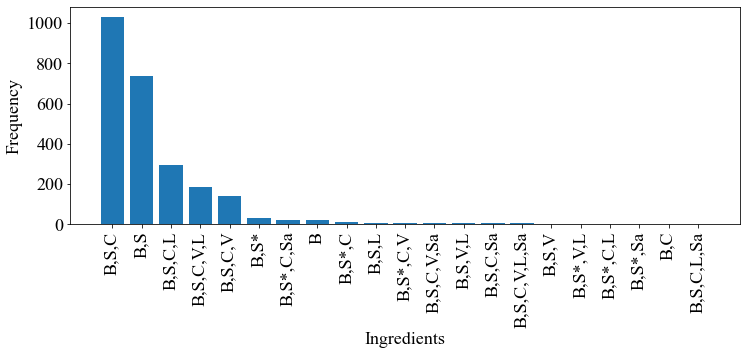

In [20]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.bar(x, h)
plt.xticks(rotation=90)
plt.xlabel("Ingredients")
plt.ylabel("Frequency")
plt.savefig("figures/ingredients_barplot.pdf", bbox_inches="tight")
plt.show()

## Train test split

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    data.loc[:, data.columns != "rating"],
    data["rating"],
    test_size=0.15,
    random_state=1,
)
X_train_raw, X_val_raw, y_train, y_val = train_test_split(
    X_train_raw, y_train, test_size=0.15, random_state=1
)
y_train_cat = y_train.astype(str)
y_val_cat = y_val.astype(str)
y_test_cat = y_test.astype(str)

In [23]:
print(X_train_raw.shape)
print(y_train.shape)
print(X_val_raw.shape)
print(y_val.shape)
print(X_test_raw.shape)
print(y_test.shape)

(1869, 10)
(1869,)
(330, 10)
(330,)
(389, 10)
(389,)


## Pre-processing after train test split

In [24]:
# fill nan number_ingredients with median
median = X_train_raw.loc[
    (~X_train_raw["number_ingredients"].isnull()) & (X_train_raw["cocoa_percent"] < 1),
    "number_ingredients",
].median()
print(median)

X_train_raw.loc[
    X_train_raw["number_ingredients"].isnull(),
    "number_ingredients",
] = median
X_val_raw.loc[
    X_val_raw["number_ingredients"].isnull(),
    "number_ingredients",
] = median
X_test_raw.loc[
    X_test_raw["number_ingredients"].isnull(),
    "number_ingredients",
] = median

3.0


In [25]:
X_train_raw

,ref,company_manufacturer,company_location,review_date,country_of_bean_origin,specific_bean_origin_or_bar_name,cocoa_percent,ingredients,most_memorable_characteristics,number_ingredients
1439,1395,Lonohana,U.S.A.,2014,U.S.A.,"O'ahu Island, Haleiwa E, 2014",0.75,"B,S,C,V","dairy, pudding",4.0
1833,1415,Pacari,Ecuador,2014,Ecuador,Cumbia,0.70,"B,S,C,L","savory, smokey",4.0
170,600,Artisan du Chocolat,U.K.,2010,Vietnam,Ba Ria Vung Tau Province,0.72,"B,S,C","unrefined, distinct spicey",3.0
2461,2744,Vesta,U.S.A.,2022,Guatemala,Guatemala,0.78,"B,S*,C","rich cocoa, fruit, bitter, molasses",3.0
1308,241,Kallari (Ecuatoriana),Ecuador,2008,Ecuador,Sisa 36hr/ W. F. blend prototype,0.70,"B,S,C,V","creamy, mild marshmallow",4.0
...,...,...,...,...,...,...,...,...,...,...
2530,1042,Woodblock,U.S.A.,2013,Trinidad,"Gran Couva, batch 1",0.70,"B,S","creamy, woody, mild metallic",2.0
44,2438,Aelan,Vanuatu,2019,Vanuatu,"Malekula Island, batch M10/19",0.70,"B,S","unrefined, sweet, metallic",2.0
1930,2622,Potomac,U.S.A.,2021,Peru,"Ucayali, batch 200105",0.70,"B,S","anise, cocoa, dried fruit",2.0
1247,725,Idilio (Felchlin),Switzerland,2011,Venezuela,Coopertiva Amazona,0.72,"B,S,C","creamy, cocoa, lemon",3.0


# Feature Engineering

In [26]:
X_train = X_train_raw.copy()
X_val = X_val_raw.copy()
X_test = X_test_raw.copy()

In [27]:
features_dict = {
    "baseline": ["cocoa_percent", "number_ingredients"],
    "one_hot_encoded": {
        "company_manufacturer": [],
        "company_location": [],
        "country_of_bean_origin": [],
    },
    "target_encoded": {
        "company_manufacturer": [],
        "company_location": [],
        "country_of_bean_origin": [],
    },
    "ingredients": {"dummies": [], "number_scaled": []},
    "most_memorable_characteristics": {"50%": [], "80%": [], "95%": []},
}

## Review Date

In [28]:
dates = X_train_raw["review_date"].unique()
dates.sort()

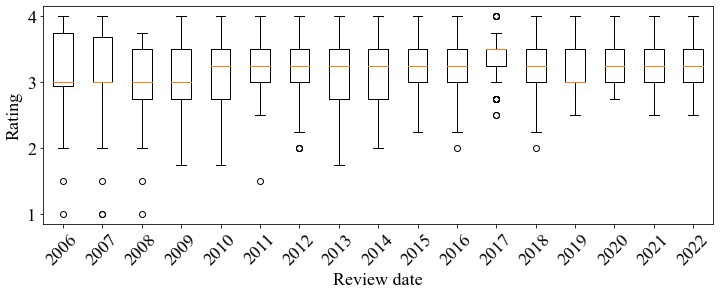

In [29]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.boxplot([y_train[X_train_raw["review_date"] == rd] for rd in dates], labels=dates)
plt.xticks(rotation=45)
plt.xlabel("Review date")
plt.ylabel("Rating")
plt.savefig("figures/review_date_boxplot.pdf", bbox_inches="tight")
plt.show()

In [30]:
# label encoding
min_date = X_train["review_date"].min()
X_train.loc[:, "review_date"] = X_train_raw.loc[:, "review_date"] - min_date
X_val.loc[:, "review_date"] = X_val_raw.loc[:, "review_date"] - min_date
X_test.loc[:, "review_date"] = X_test_raw.loc[:, "review_date"] - min_date
X_val.loc[:, "review_date"].unique()

array([ 9,  6,  3, 12, 13,  2,  8,  1, 16,  4,  5, 10, 11,  7, 15, 14,  0],
      dtype=int64)

In [31]:
X_train["review_date"].corr(y_train)

0.11431817568054758

In [32]:
from sklearn.linear_model import LinearRegression

In [33]:
lm = LinearRegression()
lm.fit(np.array(X_train["review_date"]).reshape(-1, 1), y_train)
print("intercept:\t", round(lm.intercept_, 4))
print("coefficient:\t", round(lm.coef_[0], 4))

intercept:	 3.0984
coefficient:	 0.0124


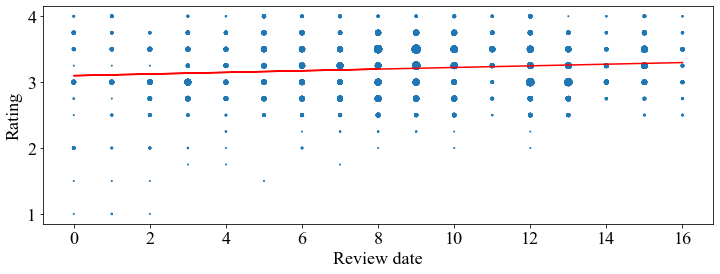

In [34]:
x = X_train["review_date"]

plt.subplots(figsize=(12, 4))
scatter_with_dot_size(x, y_train)
plt.plot(x, lm.coef_ * x + lm.intercept_, color="red")
plt.xlabel("Review date")
plt.ylabel("Rating")
plt.savefig("figures/rating_vs_review_date.pdf", bbox_inches="tight")
plt.show()

In [35]:
from statsmodels.api import OLS, add_constant
from statsmodels.stats.diagnostic import het_white

In [36]:
x = add_constant(np.array(X_train["review_date"]))
res = OLS(y_train, x).fit()

In [37]:
white_test = het_white(res.resid, res.model.exog)
print("LM-Test p-value:", white_test[1])  # << 0.05

LM-Test p-value: 2.13056964313503e-22


In [38]:
x = np.array(X_train["review_date"].apply(lambda x: x ^ 2))
print("correlation with rating:", pd.Series(x).corr(y_train))
X = add_constant(x)
res = OLS(y_train, X).fit()
white_test = het_white(res.resid, res.model.exog)
print("LM-Test p-value:\t", white_test[1])  # << 0.05

correlation with rating: 0.023106962375003173
LM-Test p-value:	 1.3600569063787788e-12


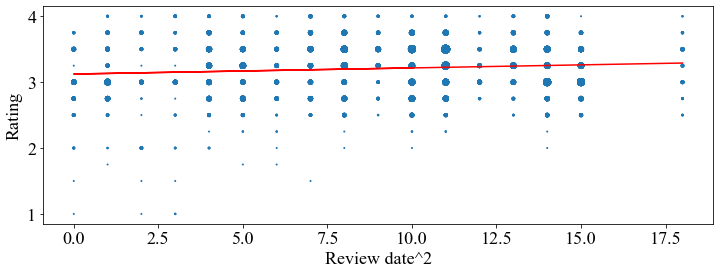

In [39]:
plt.subplots(figsize=(12, 4))
scatter_with_dot_size(x, y_train)
plt.plot(x, res.params.x1 * x + res.params.const, color="red")
plt.xlabel("Review date^2")
plt.ylabel("Rating")
plt.show()

In [40]:
x = X_train["review_date"]
y = y_train.apply(math.log)
print("correlation with rating:", x.corr(y))
X = add_constant(x)
res = OLS(y, X).fit()
white_test = het_white(res.resid, res.model.exog)
print("LM-Test p-value:\t", white_test[1])  # << 0.05

correlation with rating: 0.13730101617599713
LM-Test p-value:	 1.968918067731626e-19


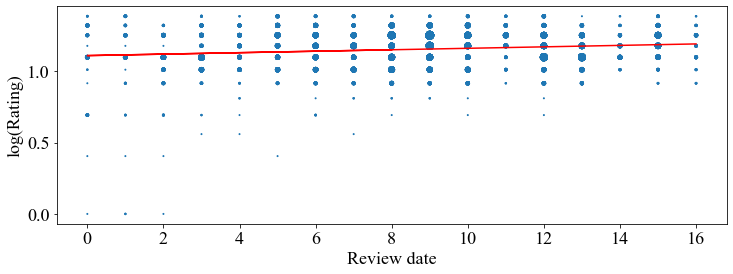

In [41]:
plt.subplots(figsize=(12, 4))
scatter_with_dot_size(x, y)
plt.plot(x, res.params.review_date * x + res.params.const, color="red")
plt.xlabel("Review date")
plt.ylabel("log(Rating)")
plt.show()

In [42]:
features_dict["baseline"] += ["review_date"]
features_dict

{'baseline': ['cocoa_percent', 'number_ingredients', 'review_date'],
 'one_hot_encoded': {'company_manufacturer': [],
  'company_location': [],
  'country_of_bean_origin': []},
 'target_encoded': {'company_manufacturer': [],
  'company_location': [],
  'country_of_bean_origin': []},
 'ingredients': {'dummies': [], 'number_scaled': []},
 'most_memorable_characteristics': {'50%': [], '80%': [], '95%': []}}

## Features with many categories

In [43]:
locations_counts = X_train["company_location"].value_counts()
locations = locations_counts.loc[locations_counts >= 25].index

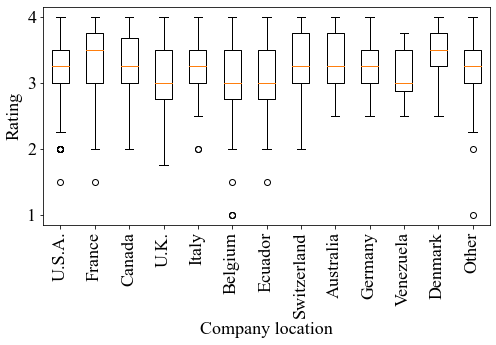

In [44]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.boxplot(
    [y_train[X_train["company_location"] == loc] for loc in locations],
    labels=locations,
    widths=0.5,
)
ax.boxplot(
    y_train[~X_train["company_location"].isin(locations)],
    positions=[len(locations) + 1],
    labels=["Other"],
    widths=0.5,
)

plt.xticks(rotation=90)
plt.xlabel("Company location")
plt.ylabel("Rating")
plt.savefig("figures/company_location_boxplot.pdf", bbox_inches="tight")
plt.show()

In [45]:
from category_encoders import OneHotEncoder, TargetEncoder

In [46]:
def apply_encoding(col_name, crit_value):
    # compute the number of observations per category
    counts = X_train_raw[col_name].value_counts()

    # find large enough categories
    categories = counts[counts > crit_value].index

    # create column where small categories are aggregated as "other"
    col_agg = col_name + "_agg"
    X_train_raw[col_agg] = X_train_raw[col_name]
    X_train_raw.loc[~X_train_raw[col_agg].isin(categories), col_agg] = "other"
    X_val_raw[col_agg] = X_val_raw[col_name]
    X_val_raw.loc[~X_val_raw[col_agg].isin(categories), col_agg] = "other"
    X_test_raw[col_agg] = X_test_raw[col_name]
    X_test_raw.loc[~X_test_raw[col_agg].isin(categories), col_agg] = "other"

    # one hot encoding
    encoder_oh = OneHotEncoder(cols=col_agg, use_cat_names=True)
    encoded_oh_train = encoder_oh.fit_transform(X_train_raw, y_train)
    encoded_oh_val = encoder_oh.transform(X_val_raw)
    encoded_oh_test = encoder_oh.transform(X_test_raw)
    cols_enc_oh = [
        name
        for name in filter(
            lambda x: x.startswith(col_agg) & ~x.endswith("other"),
            encoded_oh_train.columns,
        )
    ]
    X_train[cols_enc_oh] = encoded_oh_train[cols_enc_oh]
    X_val[cols_enc_oh] = encoded_oh_val[cols_enc_oh]
    X_test[cols_enc_oh] = encoded_oh_test[cols_enc_oh]
    features_dict["one_hot_encoded"][col_name] = cols_enc_oh

    # target encoding
    encoder_t = TargetEncoder(
        cols=col_name, handle_unknown="value", min_samples_leaf=20, smoothing=10
    )
    encoded_t_train = encoder_t.fit_transform(X_train_raw, y_train)
    encoded_t_val = encoder_t.transform(X_val_raw)
    encoded_t_test = encoder_t.transform(X_test_raw)
    X_train[col_name + "_encoded_t"] = encoded_t_train[col_name]
    X_val[col_name + "_encoded_t"] = encoded_t_val[col_name]
    X_test[col_name + "_encoded_t"] = encoded_t_test[col_name]
    features_dict["target_encoded"][col_name] = col_name + "_encoded_t"

In [47]:
apply_encoding("company_manufacturer", crit_value=25)
apply_encoding("company_location", crit_value=25)
apply_encoding("country_of_bean_origin", crit_value=50)

In [48]:
# percentage of observations where company location and country of bean origin coincide
len(
    X_train.loc[
        X_train["company_location"] == X_train["country_of_bean_origin"],
    ]
) / len(X_train)

0.12627073301230604

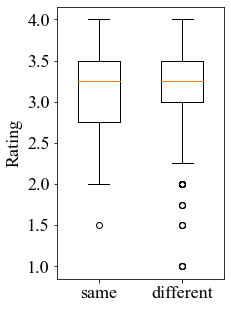

In [49]:
fig, ax = plt.subplots(figsize=(3, 5))

ax.boxplot(
    y_train[X_train["company_location"] == X_train["country_of_bean_origin"]],
    positions=[0],
    labels=["same"],
    widths=0.5,
)
ax.boxplot(
    y_train[X_train["company_location"] != X_train["country_of_bean_origin"]],
    positions=[1],
    labels=["different"],
    widths=0.5,
)

plt.ylabel("Rating")
plt.savefig("figures/location_vs_bean_origin.pdf", bbox_inches="tight")
plt.show()

## Ingredients

In [50]:
index_missing_train = X_train_raw.loc[
    X_train_raw["ingredients"].isnull(),
].index
index_missing_val = X_val_raw.loc[
    X_val_raw["ingredients"].isnull(),
].index
index_missing_test = X_test_raw.loc[
    X_test_raw["ingredients"].isnull(),
].index
len(index_missing_test) + len(index_missing_val) + len(index_missing_train)

73

In [51]:
ingredients_list = ["sugar", "sweetener", "cocoa_butter", "vanilla", "lecithin", "salt"]
ingredients_abbrev = ["S,", "S\*", "C", "V", "L", "Sa"]

In [52]:
ingredients_df_train = pd.DataFrame(columns=ingredients_list)
ingredients_df_val = ingredients_df_train.copy()
ingredients_df_test = ingredients_df_train.copy()

for i, a in enumerate(ingredients_abbrev):
    ingredients_df_train.loc[:, ingredients_list[i]] = X_train_raw["ingredients"].str.contains(a, na=False)
    ingredients_df_val.loc[:, ingredients_list[i]] = X_val_raw["ingredients"].str.contains(a, na=False)
    ingredients_df_test.loc[:, ingredients_list[i]] = X_test_raw["ingredients"].str.contains(a, na=False)

In [53]:
# sugar is abbreviated with "S," in the list above to avoid confusion with sweetener (S*)
# need to account for ingredients ending with "S" and thus having no "," in the end
ingredients_df_train.loc[:, "sugar"] = ingredients_df_train.loc[:, "sugar"] | X_train_raw["ingredients"].str.endswith("S")
ingredients_df_val.loc[:, "sugar"] = ingredients_df_val.loc[:, "sugar"] | X_val_raw["ingredients"].str.endswith("S")
ingredients_df_test.loc[:, "sugar"] = ingredients_df_test.loc[:, "sugar"] | X_test_raw["ingredients"].str.endswith("S")

In [54]:
X_train[ingredients_list] = ingredients_df_train.astype(int)
X_val[ingredients_list] = ingredients_df_val.astype(int)
X_test[ingredients_list] = ingredients_df_test.astype(int)

In [55]:
features_dict["ingredients"]["dummies"] = ingredients_list

In [56]:
h = X_train[features_dict["ingredients"]["dummies"]].mean().sort_values(ascending=False)
h

sugar           0.932049
cocoa_butter    0.663456
lecithin        0.199572
vanilla         0.134296
sweetener       0.030498
salt            0.013376
dtype: float64

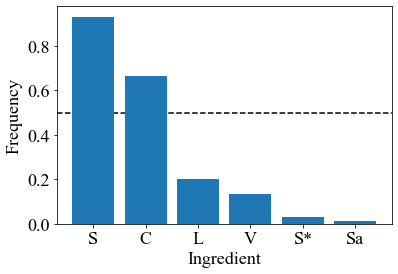

In [57]:
plt.bar(["S", "C", "L", "V", "S*", "Sa"], h, zorder=2)
plt.axhline(0.5, c="black", ls="--", zorder=1)
plt.xlabel("Ingredient")
plt.ylabel("Frequency")
plt.savefig("figures/ingredients_seperated.pdf", bbox_inches="tight")
plt.show()

In [58]:
X_train.loc[index_missing_train, ["sugar", "cocoa_butter"]] = 1
X_val.loc[index_missing_val, ["sugar", "cocoa_butter"]] = 1
X_test.loc[index_missing_test, ["sugar", "cocoa_butter"]] = 1

### Transform number of ingredients

In [59]:
num_ingr = X_train["number_ingredients"]

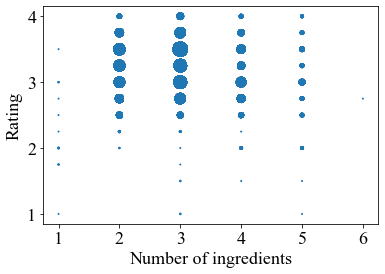

In [60]:
scatter_with_dot_size(num_ingr, y_train)
plt.xlabel("Number of ingredients")
plt.ylabel("Rating")
plt.savefig("figures/rating_vs_number_ingredients.pdf", bbox_inches="tight")
plt.show()

In [61]:
num_ingr_scaled = (num_ingr - num_ingr.mean()) / num_ingr.std()

In [62]:
print("raw: \t", num_ingr_scaled.corr(y_train))
print("abs: \t", abs(num_ingr_scaled).corr(y_train))
print("^2: \t", (num_ingr_scaled**2).corr(y_train))
print("^4: \t", (num_ingr_scaled**4).corr(y_train))    
print("exp: \t", num_ingr_scaled.apply(lambda x: math.exp(x)).corr(y_train))

raw: 	 -0.05651595085068437
abs: 	 -0.12671139067150586
^2: 	 -0.13996002920752337
^4: 	 -0.13239653849806676
exp: 	 -0.09433699943030467


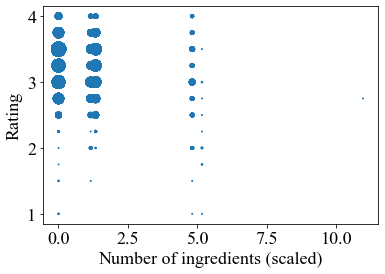

In [63]:
scatter_with_dot_size(num_ingr_scaled**2, y_train)
plt.xlabel("Number of ingredients (scaled)")
plt.ylabel("Rating")
plt.savefig("figures/rating_vs_number_ingredients_scaled.pdf", bbox_inches="tight")
plt.show()

In [64]:
X_train["number_ingredients_scaled"] = num_ingr_scaled**2

num_ingr_val = X_val["number_ingredients"]
X_val["number_ingredients_scaled"] = ((num_ingr_val - num_ingr_val.mean()) / num_ingr_val.std())**2

num_ingr_test = X_test["number_ingredients"]
X_test["number_ingredients_scaled"] = ((num_ingr_test - num_ingr_test.mean()) / num_ingr_test.std())**2

In [65]:
features_dict["ingredients"]["number_scaled"] = "number_ingredients_scaled"

## Most memorable characteristics

In [66]:
from tensorflow_hub import load, KerasLayer
from sklearn.decomposition import PCA

In [67]:
# load pretrained model
model_url = "https://tfhub.dev/google/Wiki-words-250-with-normalization/2"
#model_url = "https://tfhub.dev/google/nnlm-en-dim50-with-normalization/2"
embed = load(model_url)

In [68]:
# apply pretrained text embedding
flavors_embedded_train = embed(X_train_raw["most_memorable_characteristics"])
flavors_embedded_val = embed(X_val_raw["most_memorable_characteristics"])
flavors_embedded_test = embed(X_test_raw["most_memorable_characteristics"])

In [69]:
pca = PCA(n_components=250)
pca.fit(flavors_embedded_train)
evr_cum = pca.explained_variance_ratio_.cumsum()

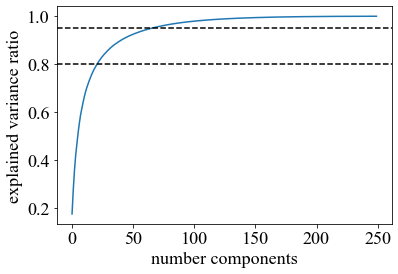

In [70]:
plt.plot(evr_cum)
plt.axhline(0.8, c="black", ls="--")
plt.axhline(0.95, c="black", ls="--")
plt.xlabel("number components")
plt.ylabel("explained variance ratio")
plt.show()

In [71]:
for ratio in [0.5, 0.8, 0.95]:
    i = np.min(np.where(evr_cum >= ratio))
    print(
        f"The first {i+1} components explain {round(evr_cum[i]*100,2)}% of the variance."
    )

The first 6 components explain 51.47% of the variance.
The first 22 components explain 80.46% of the variance.
The first 67 components explain 95.12% of the variance.


In [72]:
dim = np.min(np.where(evr_cum >= 0.95)) + 1

In [73]:
pca = PCA(n_components=dim)
flavors_pca_train = pca.fit_transform(flavors_embedded_train)
flavors_pca_val = pca.transform(flavors_embedded_val)
flavors_pca_test = pca.transform(flavors_embedded_test)
flavors_pca_test.shape

(389, 67)

In [74]:
col_names = ["flavor" + str(i + 1) for i in range(dim)]

In [75]:
X_train.loc[:, col_names] = pd.DataFrame(flavors_pca_train, columns=col_names, index=X_train.index)
X_val.loc[:, col_names] = pd.DataFrame(flavors_pca_val, columns=col_names, index=X_val.index)
X_test.loc[:, col_names] = pd.DataFrame(flavors_pca_test, columns=col_names, index=X_test.index)

In [76]:
features_dict["most_memorable_characteristics"]["50%"] = [
    "flavor" + str(i + 1) for i in range(np.min(np.where(evr_cum >= 0.5)) + 1)
]
features_dict["most_memorable_characteristics"]["80%"] = [
    "flavor" + str(i + 1) for i in range(np.min(np.where(evr_cum >= 0.80)) + 1)
]
features_dict["most_memorable_characteristics"]["95%"] = [
    "flavor" + str(i + 1) for i in range(np.min(np.where(evr_cum >= 0.95)) + 1)
]

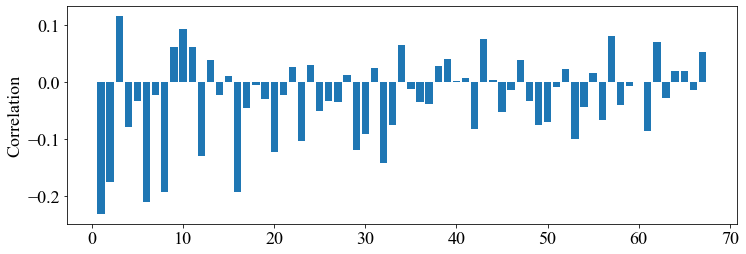

In [77]:
corr = X_train.loc[:, col_names].apply(y_train.corr)
plt.subplots(figsize=(12,4))
plt.bar(range(1,68), corr)
plt.ylabel("Correlation")
plt.savefig("figures/correlation_characteristics.pdf")
plt.show()

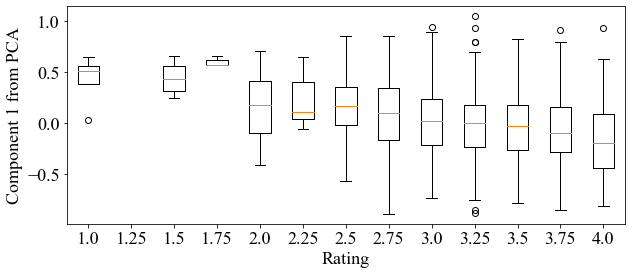

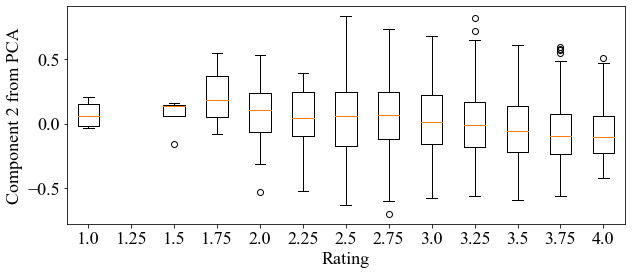

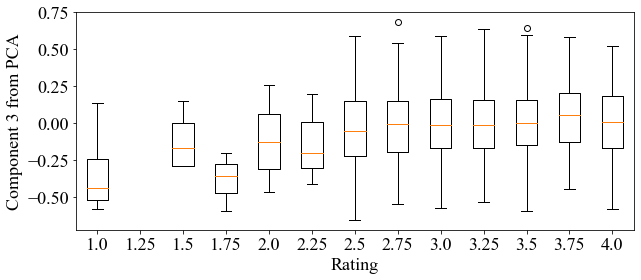

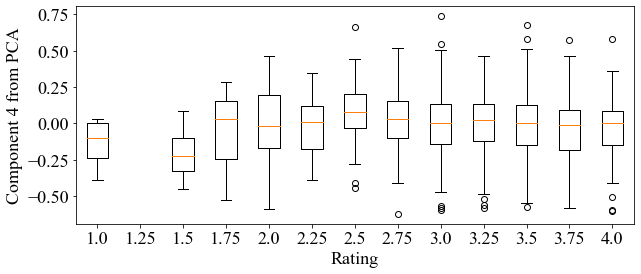

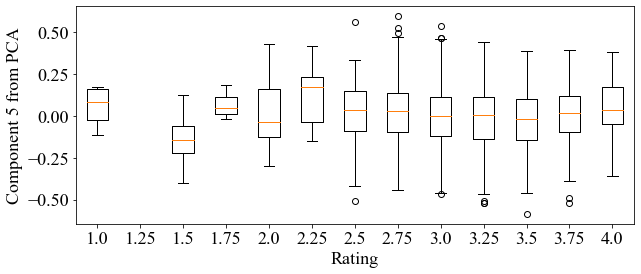

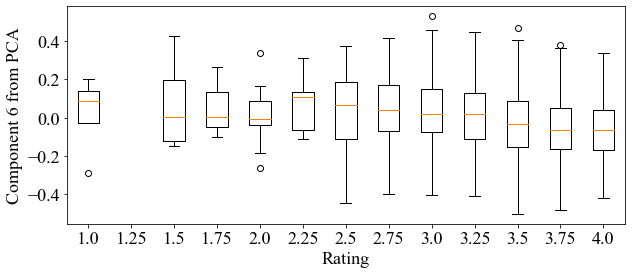

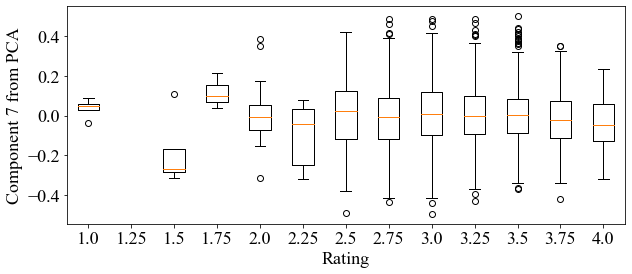

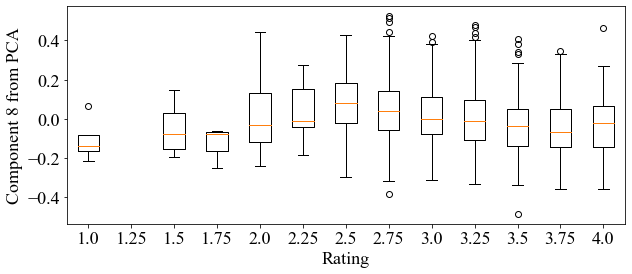

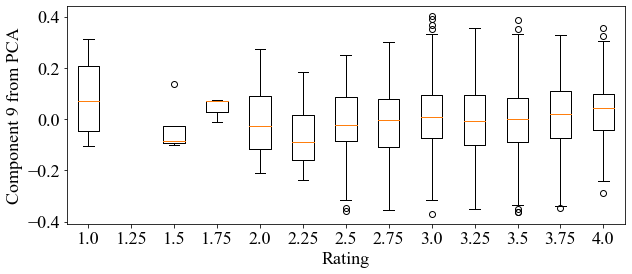

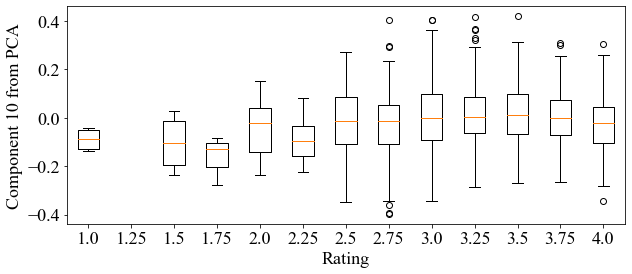

In [78]:
ratings = np.arange(1,4.25,0.25)
for i in range(1,11):
    plt.subplots(figsize=(10,4))
    plt.boxplot([X_train.loc[y_train==r,"flavor"+str(i)] for r in ratings], labels = ratings)
    plt.xlabel("Rating")
    plt.ylabel(f"Component {i} from PCA")
    plt.show()

## Cocoa percent

In [79]:
x = X_train["cocoa_percent"]

In [80]:
print("raw: \t", x.corr(y_train))
print("^2: \t", (x**2).corr(y_train))
print("^3: \t", (x**3).corr(y_train))
print("^4: \t", (x**4).corr(y_train))
print("exp: \t", x.apply(lambda x: math.exp(x)).corr(y_train))
print("log: \t", x.apply(lambda x: math.log(x)).corr(y_train))

raw: 	 -0.135177792630391
^2: 	 -0.151207676165763
^3: 	 -0.16546802676188602
^4: 	 -0.17760685052439226
exp: 	 -0.14732450430840074
log: 	 -0.11778575497479639


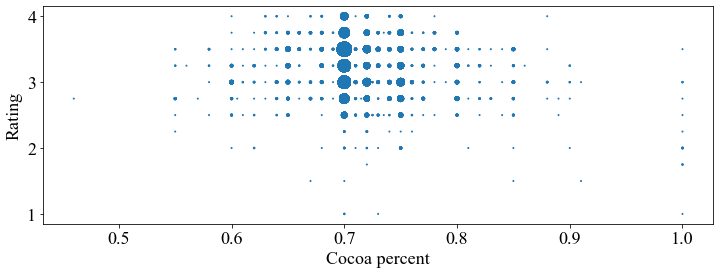

In [81]:
c = Counter(zip(x, y_train))
s = [c[(n, r)] for n, r in zip(x, y_train)]

plt.subplots(figsize=(12, 4))
plt.scatter(x, y_train, marker="o", s=s)
plt.xlabel("Cocoa percent")
plt.ylabel("Rating")
plt.savefig("figures/rating_vs_cocoa_percent.pdf", bbox_inches="tight")
plt.show()

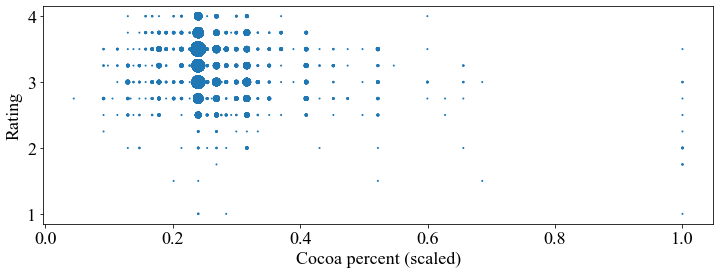

In [82]:
x_scaled = x**4
c = Counter(zip(x_scaled, y_train))
s = [c[(n, r)] for n, r in zip(x_scaled, y_train)]

plt.subplots(figsize=(12, 4))
plt.scatter(x_scaled, y_train, marker="o", s=s)
plt.xlabel("Cocoa percent (scaled)")
plt.ylabel("Rating")
# plt.savefig("figures/rating_vs_cocoa_percent.pdf", bbox_inches="tight")
plt.show()

## Final train, val, test data

In [83]:
features_dict

{'baseline': ['cocoa_percent', 'number_ingredients', 'review_date'],
 'one_hot_encoded': {'company_manufacturer': ['company_manufacturer_agg_Soma',
   'company_manufacturer_agg_Arete',
   'company_manufacturer_agg_Fresco'],
  'company_location': ['company_location_agg_U.S.A.',
   'company_location_agg_Ecuador',
   'company_location_agg_U.K.',
   'company_location_agg_France',
   'company_location_agg_Belgium',
   'company_location_agg_Canada',
   'company_location_agg_Venezuela',
   'company_location_agg_Germany',
   'company_location_agg_Australia',
   'company_location_agg_Italy',
   'company_location_agg_Switzerland'],
  'country_of_bean_origin': ['country_of_bean_origin_agg_Ecuador',
   'country_of_bean_origin_agg_Vietnam',
   'country_of_bean_origin_agg_Peru',
   'country_of_bean_origin_agg_Venezuela',
   'country_of_bean_origin_agg_Blend',
   'country_of_bean_origin_agg_Dominican Republic',
   'country_of_bean_origin_agg_Nicaragua',
   'country_of_bean_origin_agg_Madagascar',
   

In [84]:
X_train

,ref,company_manufacturer,company_location,review_date,country_of_bean_origin,specific_bean_origin_or_bar_name,cocoa_percent,ingredients,most_memorable_characteristics,number_ingredients,...,flavor58,flavor59,flavor60,flavor61,flavor62,flavor63,flavor64,flavor65,flavor66,flavor67
1439,1395,Lonohana,U.S.A.,8,U.S.A.,"O'ahu Island, Haleiwa E, 2014",0.75,"B,S,C,V","dairy, pudding",4.0,...,0.026457,0.079100,-0.045164,-0.065261,0.000463,-0.023420,-0.016858,-0.033685,-0.035416,-0.013299
1833,1415,Pacari,Ecuador,8,Ecuador,Cumbia,0.70,"B,S,C,L","savory, smokey",4.0,...,0.109953,-0.022759,-0.030492,0.058466,0.020413,0.027936,0.007880,-0.027941,-0.017282,-0.042693
170,600,Artisan du Chocolat,U.K.,4,Vietnam,Ba Ria Vung Tau Province,0.72,"B,S,C","unrefined, distinct spicey",3.0,...,-0.023614,0.008613,-0.008416,0.016576,-0.036723,0.073578,0.028112,-0.023815,0.015744,-0.056063
2461,2744,Vesta,U.S.A.,16,Guatemala,Guatemala,0.78,"B,S*,C","rich cocoa, fruit, bitter, molasses",3.0,...,-0.001196,-0.009264,-0.011786,0.021751,-0.005613,-0.002500,-0.008947,-0.018522,0.027443,-0.028108
1308,241,Kallari (Ecuatoriana),Ecuador,2,Ecuador,Sisa 36hr/ W. F. blend prototype,0.70,"B,S,C,V","creamy, mild marshmallow",4.0,...,-0.006897,0.002459,-0.030924,-0.001627,-0.007403,0.072724,0.026020,0.048901,-0.017577,-0.025262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2530,1042,Woodblock,U.S.A.,7,Trinidad,"Gran Couva, batch 1",0.70,"B,S","creamy, woody, mild metallic",2.0,...,0.007624,0.020381,0.003764,-0.011612,0.011574,-0.004715,0.038695,-0.008974,-0.017368,0.031324
44,2438,Aelan,Vanuatu,13,Vanuatu,"Malekula Island, batch M10/19",0.70,"B,S","unrefined, sweet, metallic",2.0,...,0.008103,-0.020928,-0.014799,0.023090,0.000581,0.018509,0.002218,-0.003325,0.012190,-0.001444
1930,2622,Potomac,U.S.A.,15,Peru,"Ucayali, batch 200105",0.70,"B,S","anise, cocoa, dried fruit",2.0,...,-0.001784,0.046592,-0.006839,-0.036034,-0.001428,0.007866,0.026992,0.032317,-0.054319,-0.012861
1247,725,Idilio (Felchlin),Switzerland,5,Venezuela,Coopertiva Amazona,0.72,"B,S,C","creamy, cocoa, lemon",3.0,...,-0.016622,0.015423,-0.000835,0.006980,0.005027,0.012303,0.009871,0.008044,-0.024160,0.010786


In [85]:
print("Training:\t", X_train.shape)
print("Validation:\t", X_val.shape)
print("Test:\t\t", X_test.shape)

Training:	 (1869, 113)
Validation:	 (330, 113)
Test:		 (389, 113)


In [86]:
# If no validation data is needed the model is fitted to the combined training and validation data
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])
print("Training + Validation:")
print(X_train_val.shape)
print(y_train_val.shape)

Training + Validation:
(2199, 113)
(2199,)


# Benchmark Models

## Simple Median Model

In [104]:
class simple_median_model:
    median = None

    def fit(self, X=None, y=None):
        self.median = y.median()

    def predict(self, X):
        return np.repeat(self.median, X.shape[0])

In [105]:
median_model = simple_median_model()
median_model.fit(y=y_train_val)
print_scores(median_model.predict(X_train), median_model.predict(X_test))

MSE:		 Train: 0.1967 	Test: 0.1992
MdAE:		 Train: 0.2500 	Test: 0.2500
Accuracy:	 Train: 0.1825 	Test: 0.1825


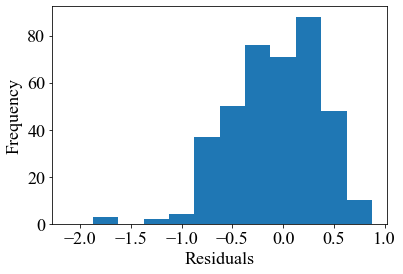

In [106]:
histogram_residuals(y_test, median_model.predict(X_test), "simple_median_model")

## Baseline Regression Model

In [107]:
features_dict["baseline"]

['cocoa_percent', 'number_ingredients', 'review_date']

In [108]:
X_train_val_bl = X_train_val.loc[:, features_dict["baseline"]]
X_test_bl = X_test.loc[:, features_dict["baseline"]]

In [109]:
X_train_val_bl.apply(y_train_val.corr)

cocoa_percent        -0.144850
number_ingredients   -0.060262
review_date           0.120959
dtype: float64

In [110]:
bl = LinearRegression()
bl.fit(X_train_val_bl, y_train_val)
print_scores(bl.predict(X_train.loc[:, features_dict["baseline"]]), bl.predict(X_test_bl))

MSE:		 Train: 0.1879 	Test: 0.1876
MdAE:		 Train: 0.2911 	Test: 0.2929
Accuracy:	 Train: 0.2006 	Test: 0.2134


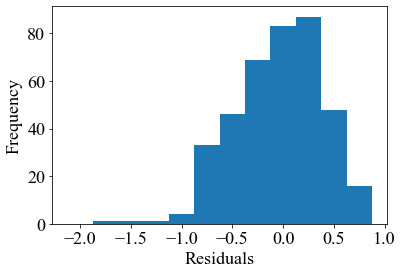

In [111]:
histogram_residuals(y_test, bl.predict(X_test_bl), "linear_regression")

# Linear Regression

## Stepwise add features

In [131]:
def linear_regression(cols):
    X_train_ = X_train.loc[:, cols]
    X_train_val_ = X_train_val.loc[:, cols]
    X_test_ = X_test.loc[:, cols]
    
    lr_ = LinearRegression()
    lr_.fit(X_train_val_, y_train_val)
    print_scores(lr_.predict(X_train_), lr_.predict(X_test_))
    
    return(lr_.predict(X_test_))

In [132]:
features_dict["baseline"]

['cocoa_percent', 'number_ingredients', 'review_date']

In [133]:
metrics_list = []

In [134]:
# baseline linear regression
cols = features_dict["baseline"]
pred = linear_regression(cols)
metrics_list.append(get_metrics(y_test, pred))

MSE:		 Train: 0.1879 	Test: 0.1876
MdAE:		 Train: 0.2911 	Test: 0.2929
Accuracy:	 Train: 0.2006 	Test: 0.2134


In [135]:
# baseline and one hot encoded features (company_manufacturer, company_location, country_of_bean_origin)
cols = features_dict["baseline"].copy()
for col in features_dict["one_hot_encoded"].keys():
    cols += features_dict["one_hot_encoded"][col]
pred = linear_regression(cols)
metrics_list.append(get_metrics(y_test, pred))

MSE:		 Train: 0.1771 	Test: 0.1832
MdAE:		 Train: 0.2870 	Test: 0.2939
Accuracy:	 Train: 0.2146 	Test: 0.2057


In [136]:
# baseline and target encoded features (company_manufacturer, company_location, country_of_bean_origin)
cols = features_dict["baseline"].copy()
for col in features_dict["target_encoded"].keys():
    cols += [features_dict["target_encoded"][col]]
pred = linear_regression(cols)
metrics_list.append(get_metrics(y_test, pred))

MSE:		 Train: 0.1419 	Test: 0.1699
MdAE:		 Train: 0.2565 	Test: 0.2922
Accuracy:	 Train: 0.2467 	Test: 0.2365


In [137]:
# baseline and ingredient dummies
cols = features_dict["baseline"] + features_dict["ingredients"]["dummies"]
pred = linear_regression(cols)
metrics_list.append(get_metrics(y_test, pred))

MSE:		 Train: 0.1819 	Test: 0.1759
MdAE:		 Train: 0.2751 	Test: 0.2751
Accuracy:	 Train: 0.2076 	Test: 0.2108


In [138]:
# baseline but number ingredients scaled and ingredient dummies
cols = (
    ["cocoa_percent", "review_date"]
    + features_dict["ingredients"]["dummies"]
    + [features_dict["ingredients"]["number_scaled"]]
)
pred = linear_regression(cols)
metrics_list.append(get_metrics(y_test, pred))

MSE:		 Train: 0.1817 	Test: 0.1752
MdAE:		 Train: 0.2776 	Test: 0.2761
Accuracy:	 Train: 0.2113 	Test: 0.2134


In [139]:
# baseline and 22 flavour features from embedding+PCA
cols = features_dict["baseline"] + features_dict["most_memorable_characteristics"]["80%"]
pred = linear_regression(cols)
metrics_list.append(get_metrics(y_test, pred))

MSE:		 Train: 0.1373 	Test: 0.1320
MdAE:		 Train: 0.2452 	Test: 0.2285
Accuracy:	 Train: 0.2659 	Test: 0.2776


In [140]:
# full model
all_cols = features_dict["baseline"].copy()
for col in features_dict["one_hot_encoded"].keys():
    all_cols += features_dict["one_hot_encoded"][col]
for col in features_dict["target_encoded"].keys():
    all_cols += [features_dict["target_encoded"][col]]
all_cols += (
    features_dict["ingredients"]["dummies"]
    + features_dict["most_memorable_characteristics"]["80%"]
)
pred = linear_regression(all_cols)
metrics_list.append(get_metrics(y_test, pred))

MSE:		 Train: 0.0995 	Test: 0.1257
MdAE:		 Train: 0.1982 	Test: 0.2138
Accuracy:	 Train: 0.3119 	Test: 0.3316


In [141]:
pd.DataFrame(metrics_list).apply(lambda x: round(x, 4))

,MSE,MdAE,Accuracy
0,0.1876,0.2929,0.2134
1,0.1832,0.2939,0.2057
2,0.1699,0.2922,0.2365
3,0.1759,0.2751,0.2108
4,0.1752,0.2761,0.2134
5,0.1320,0.2285,0.2776
6,0.1257,0.2138,0.3316


## Backward Elimination

In [142]:
X = X_train_val.loc[:, all_cols]

In [143]:
est = OLS(y_train_val, X).fit()
p = est.pvalues.max()
drop_cols = []

while p > 0.1:
    drop = est.pvalues[est.pvalues==p].index.to_list()
    #print("drop:", drop)
    
    drop_cols = drop_cols + drop
    X_reduced = X.loc[:, ~X.columns.isin(drop_cols)]
    est = OLS(y_train_val, X_reduced).fit()
    
    p = est.pvalues.max()

In [144]:
cols_reduced = all_cols.copy()
for c in drop_cols:
    cols_reduced.remove(c)
print(cols_reduced)

['number_ingredients', 'review_date', 'company_manufacturer_agg_Soma', 'company_manufacturer_agg_Arete', 'company_manufacturer_agg_Fresco', 'country_of_bean_origin_agg_Ecuador', 'company_manufacturer_encoded_t', 'country_of_bean_origin_encoded_t', 'sugar', 'sweetener', 'cocoa_butter', 'vanilla', 'lecithin', 'salt', 'flavor1', 'flavor2', 'flavor3', 'flavor4', 'flavor5', 'flavor6', 'flavor8', 'flavor9', 'flavor10', 'flavor11', 'flavor12', 'flavor16', 'flavor17', 'flavor18', 'flavor20']


In [145]:
X_train_reduced = X_train.loc[:, cols_reduced]
X_train_val_reduced = X_train_val.loc[:, cols_reduced]
X_test_reduced = X_test.loc[:, cols_reduced]

In [146]:
lr_reduced = LinearRegression()
lr_reduced.fit(X_train_val_reduced, y_train_val)
print_scores(lr_reduced.predict(X_train_reduced), lr_reduced.predict(X_test_reduced))

MSE:		 Train: 0.1004 	Test: 0.1261
MdAE:		 Train: 0.2002 	Test: 0.2137
Accuracy:	 Train: 0.3162 	Test: 0.3111


## Lasso

In [147]:
from sklearn.linear_model import Lasso

In [148]:
model_lasso = Lasso(alpha=0.2)
model_lasso.fit(X_train_val[all_cols], y_train_val)
print_scores(model_lasso.predict(X_train[all_cols]), model_lasso.predict(X_test[all_cols]))

MSE:		 Train: 0.1941 	Test: 0.1938
MdAE:		 Train: 0.2966 	Test: 0.2966
Accuracy:	 Train: 0.1825 	Test: 0.1825


In [149]:
alphas = np.arange(5e-05, 1e-02, 1e-05)
lasso_score = []
lasso_mse = []

for a in alphas:
    model_lasso = Lasso(alpha=a)
    model_lasso.fit(X_train[all_cols], y_train)
    score_ = model_lasso.score(X_val[all_cols], y_val)
    lasso_score.append(score_)
    mse_ = mse(model_lasso.predict(X_val[all_cols]), y_val)
    lasso_mse.append(mse_)

In [155]:
lasso_score_mse_df = pd.DataFrame({"alpha": alphas, "score": lasso_score, "MSE": lasso_mse})
lasso_score_mse_df.loc[lasso_score_mse_df["MSE"]==lasso_score_mse_df["MSE"].min(), "alpha"]

20    0.00025
Name: alpha, dtype: float64

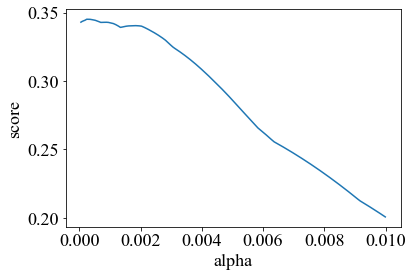

In [156]:
plt.plot(alphas, lasso_score)
plt.xlabel("alpha")
plt.ylabel("score")
plt.show()

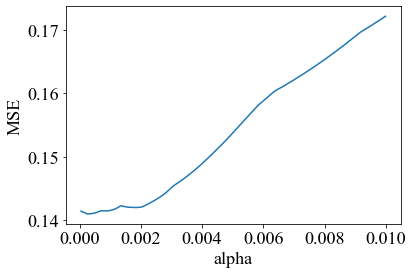

In [157]:
plt.plot(alphas, lasso_mse)
plt.xlabel("alpha")
plt.ylabel("MSE")
plt.show()

In [158]:
model_lasso = Lasso(alpha=0.00025)
model_lasso.fit(X_train[all_cols], y_train)
print_scores(model_lasso.predict(X_train[all_cols]), model_lasso.predict(X_test[all_cols]))

MSE:		 Train: 0.0989 	Test: 0.1283
MdAE:		 Train: 0.1998 	Test: 0.2241
Accuracy:	 Train: 0.3194 	Test: 0.2905


In [159]:
# features for which coefficients are set to zero:
for i, c in enumerate(model_lasso.coef_):
    if float(c) == 0:
        print(model_lasso.feature_names_in_[i])

cocoa_percent
number_ingredients
company_location_agg_Venezuela
company_location_agg_Germany
company_location_agg_Australia
company_location_agg_Switzerland
country_of_bean_origin_agg_Vietnam
country_of_bean_origin_agg_Nicaragua
country_of_bean_origin_agg_Tanzania
country_of_bean_origin_agg_Colombia
company_location_encoded_t
lecithin
flavor19
flavor22


# Random Forest

In [113]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import seaborn as sns

## with flavors

In [161]:
rf_cols = features_dict["baseline"].copy()
for col in features_dict["one_hot_encoded"].keys():
    rf_cols += features_dict["one_hot_encoded"][col]
for col in features_dict["target_encoded"].keys():
    rf_cols += [features_dict["target_encoded"][col]]
rf_cols += (
    features_dict["ingredients"]["dummies"]
    + features_dict["most_memorable_characteristics"]["95%"]
)

In [162]:
rf = RandomForestRegressor(min_samples_leaf=100, random_state=1)
rf.fit(X_train[rf_cols], y_train)
print_scores(rf.predict(X_train[rf_cols]), rf.predict(X_test[rf_cols]))

MSE:		 Train: 0.1184 	Test: 0.1611
MdAE:		 Train: 0.2175 	Test: 0.2740
Accuracy:	 Train: 0.2980 	Test: 0.2365


In [163]:
per_imp = permutation_importance(rf, X_train[rf_cols], y_train, n_repeats=1, n_jobs=-1)
pi_df = pd.DataFrame(
    data={'Feature': rf_cols, 'Permutation importance': per_imp["importances_mean"]}, 
    columns = ['Feature', 'Permutation importance']
)
pi_df.sort_values('Permutation importance', inplace=True, ascending=False)

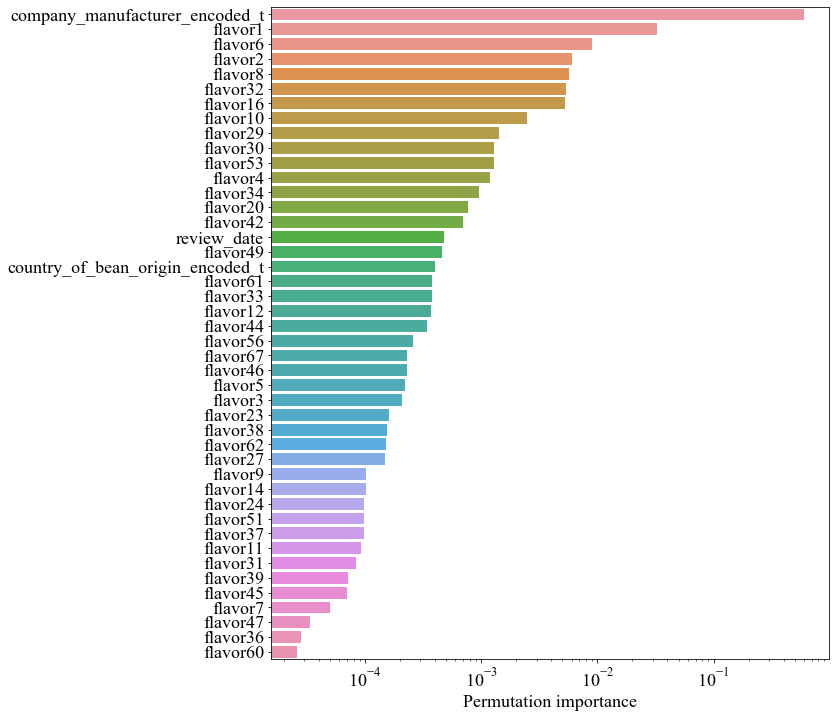

In [164]:
plt.subplots(figsize=(10,12))
sns.barplot(data=pi_df[pi_df["Permutation importance"] > 0], x='Permutation importance', y='Feature')
plt.xscale('log')
plt.ylabel("")
plt.savefig("figures/rf_flavors_feature_importance.pdf", bbox_inches="tight")
plt.show()

### Hyperparameter Tuning

In [165]:
from bayes_opt import BayesianOptimization
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

In [208]:
rf_cols = ["review_date"]
for col in features_dict["target_encoded"].keys():
    rf_cols += [features_dict["target_encoded"][col]]
rf_cols += features_dict["most_memorable_characteristics"]["95%"]
print(rf_cols)

['review_date', 'company_manufacturer_encoded_t', 'company_location_encoded_t', 'country_of_bean_origin_encoded_t', 'flavor1', 'flavor2', 'flavor3', 'flavor4', 'flavor5', 'flavor6', 'flavor7', 'flavor8', 'flavor9', 'flavor10', 'flavor11', 'flavor12', 'flavor13', 'flavor14', 'flavor15', 'flavor16', 'flavor17', 'flavor18', 'flavor19', 'flavor20', 'flavor21', 'flavor22', 'flavor23', 'flavor24', 'flavor25', 'flavor26', 'flavor27', 'flavor28', 'flavor29', 'flavor30', 'flavor31', 'flavor32', 'flavor33', 'flavor34', 'flavor35', 'flavor36', 'flavor37', 'flavor38', 'flavor39', 'flavor40', 'flavor41', 'flavor42', 'flavor43', 'flavor44', 'flavor45', 'flavor46', 'flavor47', 'flavor48', 'flavor49', 'flavor50', 'flavor51', 'flavor52', 'flavor53', 'flavor54', 'flavor55', 'flavor56', 'flavor57', 'flavor58', 'flavor59', 'flavor60', 'flavor61', 'flavor62', 'flavor63', 'flavor64', 'flavor65', 'flavor66', 'flavor67']


In [209]:
def get_rf_mse_for_params(min_samples_leaf, max_depth, n_estimators):
    params = {
        "min_samples_leaf": int(min_samples_leaf),
        "max_depth": int(max_depth),
        "n_estimators": int(n_estimators),
        "random_state": 1,
    }

    X, y = X_train_val[rf_cols].values, y_train_val.values
    kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
    mse_list = []

    # label encode y in order to make it multiclass for stratified k fold
    for i_train, i_val in kf.split(X, label_encoder.fit_transform(y)):
        rf = RandomForestRegressor(**params)
        rf.fit(X[i_train], y[i_train])
        mse_list.append(mse(y[i_val], rf.predict(X[i_val])))

    return -1 * np.mean(mse_list)

In [212]:
# initializer optimizer with wide bounds
rf_optimizer = BayesianOptimization(
    f=get_rf_mse_for_params,
    pbounds={
        "max_depth": (1, 8),
        "min_samples_leaf": (50, 300),
        "n_estimators": (1, 300),
    },
    random_state=1
)

In [213]:
rf_optimizer.maximize(
    init_points=10,
    n_iter=90,
)
print([key + ": " + str(int(rf_optimizer.max["params"][key])) for key in rf_optimizer.max["params"].keys()])

|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
|  1        | -0.158    |  3.919    |  230.1    |  1.034    |
|  2        | -0.1369   |  3.116    |  86.69    |  28.61    |
|  3        | -0.1428   |  2.304    |  136.4    |  119.6    |
|  4        | -0.1425   |  4.772    |  154.8    |  205.9    |
|  5        | -0.1548   |  2.431    |  269.5    |  9.189    |
|  6        | -0.1425   |  5.693    |  154.3    |  168.0    |
|  7        | -0.1557   |  1.983    |  99.53    |  240.4    |
|  8        | -0.1397   |  7.778    |  128.4    |  208.0    |
|  9        | -0.1551   |  7.135    |  273.7    |  26.43    |
|  10       | -0.1558   |  1.273    |  92.46    |  263.6    |
|  11       | -0.1372   |  3.049    |  88.09    |  27.99    |
|  12       | -0.1319   |  8.0      |  62.63    |  82.27    |
|  13       | -0.1304   |  7.809    |  52.39    |  137.2    |
|  14       | -0.1355   |  8.0      |  88.85    |  153.6    |
|  15   

|  80       | -0.1558   |  1.746    |  66.88    |  183.3    |
|  81       | -0.1316   |  7.819    |  60.53    |  169.7    |
|  82       | -0.1558   |  1.89     |  65.13    |  169.2    |
|  83       | -0.1301   |  6.572    |  51.99    |  115.2    |
|  84       | -0.1426   |  2.067    |  53.12    |  145.0    |
|  85       | -0.134    |  7.878    |  77.7     |  171.7    |
|  86       | -0.1326   |  7.81     |  67.62    |  86.09    |
|  87       | -0.1305   |  6.713    |  50.19    |  49.81    |
|  88       | -0.1306   |  7.961    |  53.94    |  79.76    |
|  89       | -0.1311   |  8.0      |  57.38    |  176.4    |
|  90       | -0.1334   |  7.294    |  71.49    |  199.0    |
|  91       | -0.1339   |  7.645    |  76.61    |  190.1    |
|  92       | -0.1325   |  7.302    |  66.15    |  213.2    |
|  93       | -0.1339   |  5.301    |  76.01    |  212.6    |
|  94       | -0.1336   |  4.181    |  71.0     |  223.0    |
|  95       | -0.1317   |  6.853    |  60.34    |  223.0    |
|  96   

In [210]:
rf = RandomForestRegressor(max_depth=8, min_samples_leaf=50, n_estimators = 120, random_state=1)
rf.fit(X_train[rf_cols], y_train)
print_scores(rf.predict(X_train[rf_cols]), rf.predict(X_test[rf_cols]))

MSE:		 Train: 0.1028 	Test: 0.1528
MdAE:		 Train: 0.2003 	Test: 0.2566
Accuracy:	 Train: 0.3221 	Test: 0.2416


In [216]:
# GridSearch around the current optimium
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid={
        "max_depth": [7, 8, 9],
        "min_samples_leaf": np.arange(40, 60, 5),
        "n_estimators": np.arange(100, 140, 10),
    },
)

grid_search.fit(X_train_val[rf_cols], y_train_val)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [7, 8, 9],
                         'min_samples_leaf': array([40, 45, 50, 55]),
                         'n_estimators': array([100, 110, 120, 130])})

In [217]:
grid_search.best_params_

{'max_depth': 9, 'min_samples_leaf': 40, 'n_estimators': 100}

In [211]:
rf = RandomForestRegressor(**grid_search.best_params_, random_state=1)
rf.fit(X_train[rf_cols], y_train)
print_scores(rf.predict(X_train[rf_cols]), rf.predict(X_test[rf_cols]))

MSE:		 Train: 0.0970 	Test: 0.1511
MdAE:		 Train: 0.1901 	Test: 0.2544
Accuracy:	 Train: 0.3414 	Test: 0.2468


## without flavors

In [114]:
rf_cols = features_dict["baseline"].copy()
for col in features_dict["one_hot_encoded"].keys():
    rf_cols += features_dict["one_hot_encoded"][col]
for col in features_dict["target_encoded"].keys():
    rf_cols += [features_dict["target_encoded"][col]]
rf_cols += features_dict["ingredients"]["dummies"]

In [115]:
rf = RandomForestRegressor(min_samples_leaf=100, random_state=1)
rf.fit(X_train[rf_cols], y_train)
print_scores(rf.predict(X_train[rf_cols]), rf.predict(X_test[rf_cols]))

MSE:		 Train: 0.1277 	Test: 0.1727
MdAE:		 Train: 0.2364 	Test: 0.2664
Accuracy:	 Train: 0.2830 	Test: 0.2416


In [116]:
per_imp = permutation_importance(rf, X_train[rf_cols], y_train, n_repeats=1, n_jobs=-1)
pi_df = pd.DataFrame(
    data={'Feature': rf_cols, 'Permutation importance': per_imp["importances_mean"]}, 
    columns = ['Feature', 'Permutation importance']
)
pi_df.sort_values('Permutation importance', inplace=True, ascending=False)

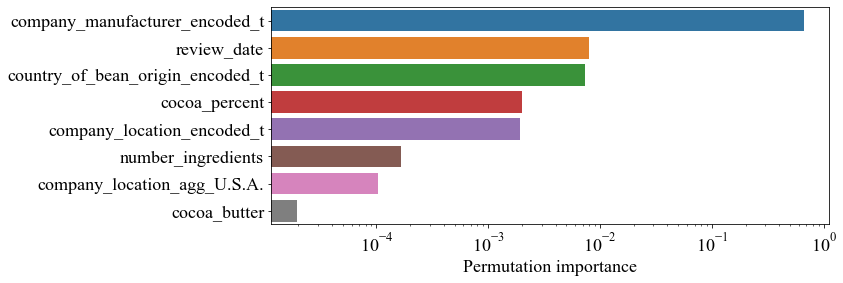

In [118]:
plt.subplots(figsize=(10,4))
sns.barplot(data=pi_df[pi_df["Permutation importance"] > 0], x='Permutation importance', y='Feature')
plt.xscale('log')
plt.ylabel("")
plt.savefig("figures/rf_feature_importance.pdf", bbox_inches="tight")
plt.show()

# Neural networks

In [87]:
from tensorflow import string
from tensorflow.keras import Model, Sequential, layers
from tensorflow import losses, metrics
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

## Pure text embedding model

Predict the rating using the column "most_memorable_characteristics" only.

In [95]:
model_url = "https://tfhub.dev/google/Wiki-words-250-with-normalization/2"
hub_layer = KerasLayer(model_url, input_shape=[], dtype=string, trainable=False, name="text_embedding")

In [103]:
model = Sequential()
model.add(hub_layer)
model.add(layers.Dense(32, activation="relu", name="dense"))
model.add(layers.Dense(1, name="output"))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_embedding (KerasLayer)  (None, 250)              252343750 
                                                                 
 dense (Dense)               (None, 32)                8032      
                                                                 
 output (Dense)              (None, 1)                 33        
                                                                 
Total params: 252,351,815
Trainable params: 8,065
Non-trainable params: 252,343,750
_________________________________________________________________


In [104]:
plot_model(model, to_file='figures/neural_net_text_embedding_architecture.pdf', show_shapes=True)

In [105]:
model.compile(
    optimizer="adam",
    loss=losses.MeanSquaredError(),
    metrics=[metrics.MeanAbsoluteError(name="MAE")],
)

In [106]:
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

In [107]:
fitted = model.fit(
    X_train["most_memorable_characteristics"],
    y_train,
    epochs=200,
    batch_size=64,
    validation_data=(X_val["most_memorable_characteristics"], y_val),
    callbacks=[early_stopping],
    verbose=1,
)

Epoch 1/200
30/30 [==============================] - 1s 22ms/step - loss: 6.2388 - MAE: 2.4158 - val_loss: 2.4192 - val_MAE: 1.4700
Epoch 2/200
30/30 [==============================] - 0s 12ms/step - loss: 1.1016 - MAE: 0.8799 - val_loss: 0.4640 - val_MAE: 0.5362
Epoch 3/200
30/30 [==============================] - 0s 13ms/step - loss: 0.5082 - MAE: 0.5607 - val_loss: 0.4421 - val_MAE: 0.5208
Epoch 4/200
30/30 [==============================] - 0s 13ms/step - loss: 0.4621 - MAE: 0.5318 - val_loss: 0.4241 - val_MAE: 0.5100
Epoch 5/200
30/30 [==============================] - 0s 14ms/step - loss: 0.4398 - MAE: 0.5177 - val_loss: 0.4143 - val_MAE: 0.5018
Epoch 6/200
30/30 [==============================] - 0s 13ms/step - loss: 0.4236 - MAE: 0.5075 - val_loss: 0.4048 - val_MAE: 0.4952
Epoch 7/200
30/30 [==============================] - 0s 14ms/step - loss: 0.4104 - MAE: 0.4991 - val_loss: 0.3956 - val_MAE: 0.4884
Epoch 8/200
30/30 [==============================] - 0s 13ms/step - loss: 0.

Epoch 63/200
30/30 [==============================] - 0s 13ms/step - loss: 0.1068 - MAE: 0.2577 - val_loss: 0.1364 - val_MAE: 0.2819
Epoch 64/200
30/30 [==============================] - 0s 2ms/step - loss: 0.1062 - MAE: 0.2568 - val_loss: 0.1369 - val_MAE: 0.2827
Epoch 65/200
30/30 [==============================] - 0s 2ms/step - loss: 0.1040 - MAE: 0.2541 - val_loss: 0.1372 - val_MAE: 0.2816
Epoch 66/200
30/30 [==============================] - 0s 12ms/step - loss: 0.1044 - MAE: 0.2545 - val_loss: 0.1359 - val_MAE: 0.2817
Epoch 67/200
30/30 [==============================] - 0s 2ms/step - loss: 0.1033 - MAE: 0.2532 - val_loss: 0.1363 - val_MAE: 0.2812
Epoch 68/200
30/30 [==============================] - 0s 3ms/step - loss: 0.1026 - MAE: 0.2521 - val_loss: 0.1364 - val_MAE: 0.2806
Epoch 69/200
30/30 [==============================] - 0s 12ms/step - loss: 0.1011 - MAE: 0.2496 - val_loss: 0.1352 - val_MAE: 0.2804
Epoch 70/200
30/30 [==============================] - 0s 12ms/step - loss

In [108]:
MAE = fitted.history['MAE']
val_MAE = fitted.history['val_MAE']
loss = fitted.history['loss']
val_loss = fitted.history['val_loss']

epochs = range(1, len(MAE) + 1)

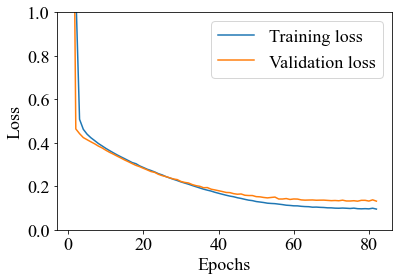

In [109]:
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.ylim(0,1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

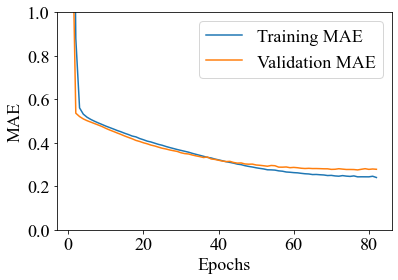

In [110]:
plt.plot(epochs, MAE, label='Training MAE')
plt.plot(epochs, val_MAE, label='Validation MAE')
plt.ylim(0,1)
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [111]:
y_pred_nn_train = model.predict(X_train["most_memorable_characteristics"], verbose=False).reshape(-1)
y_pred_nn = model.predict(X_test["most_memorable_characteristics"], verbose=False).reshape(-1)

In [112]:
print_scores(y_pred_nn_train, y_pred_nn)

MSE:		 Train: 0.0952 	Test: 0.1091
MdAE:		 Train: 0.2043 	Test: 0.2121
Accuracy:	 Train: 0.3167 	Test: 0.3342


In [ ]:
histogram_residuals(y_test, y_pred_nn, "text_embedding")

## with two input layers

In [119]:
flavour_col = ["most_memorable_characteristics"]

other_cols = features_dict["baseline"].copy() + features_dict["one_hot_encoded"]["company_manufacturer"]
for col in features_dict["target_encoded"].keys():
    other_cols += [features_dict["target_encoded"][col]]
other_cols += features_dict["ingredients"]["dummies"]

num_other_features = len(other_cols)
num_other_features

15

In [120]:
# flavors
model_url = "https://tfhub.dev/google/Wiki-words-250-with-normalization/2"
flavors_input = layers.Input(shape=(), dtype="string", name="input_flavors")
flavors_embedding = KerasLayer(
    model_url, input_shape=[], dtype=string, trainable=False, name="embedding"
)(flavors_input)
flavors_dense = layers.Dense(units=32, activation="relu", name="dense_flavors")(flavors_embedding)

# other features
other_input = layers.Input(shape=(num_other_features,), name="input_other")
other_dense = layers.Dense(8, activation="relu", name="dense_other")(other_input)
other_dropout = layers.Dropout(0.3, name="dropout")(other_dense)

# Merge all features into a single large vector via concatenation
x = layers.concatenate([flavors_dense, other_dropout], name="concat")

output = layers.Dense(1, name="dense_output")(x)

# Instantiate the model
nn_model_complex = Model(
    inputs=[flavors_input, other_input],
    outputs=[output],
)

In [121]:
plot_model(nn_model_complex, to_file='figures/neural_net_architecture.pdf', show_shapes=True)

In [122]:
nn_model_complex.compile(
    optimizer="adam",
    loss=losses.MeanSquaredError(),
    metrics=[metrics.MeanAbsoluteError(name="MAE")],
)

In [123]:
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

In [124]:
fitted = nn_model_complex.fit(
    [X_train["most_memorable_characteristics"], X_train[other_cols]],
    y_train,
    epochs=200,
    batch_size=32,
    validation_data=([X_val["most_memorable_characteristics"], X_val[other_cols]], y_val),
    callbacks=[early_stopping],
    verbose=1,
)

Epoch 1/200
59/59 [==============================] - 1s 12ms/step - loss: 1.5286 - MAE: 0.9927 - val_loss: 0.3363 - val_MAE: 0.4609
Epoch 2/200
59/59 [==============================] - 0s 7ms/step - loss: 0.7571 - MAE: 0.6949 - val_loss: 0.3103 - val_MAE: 0.4399
Epoch 3/200
59/59 [==============================] - 0s 8ms/step - loss: 0.5127 - MAE: 0.5685 - val_loss: 0.2975 - val_MAE: 0.4262
Epoch 4/200
59/59 [==============================] - 0s 7ms/step - loss: 0.4309 - MAE: 0.5167 - val_loss: 0.2879 - val_MAE: 0.4153
Epoch 5/200
59/59 [==============================] - 0s 7ms/step - loss: 0.3580 - MAE: 0.4737 - val_loss: 0.2655 - val_MAE: 0.3955
Epoch 6/200
59/59 [==============================] - 0s 8ms/step - loss: 0.2956 - MAE: 0.4301 - val_loss: 0.2581 - val_MAE: 0.3861
Epoch 7/200
59/59 [==============================] - 0s 7ms/step - loss: 0.2710 - MAE: 0.4122 - val_loss: 0.2276 - val_MAE: 0.3657
Epoch 8/200
59/59 [==============================] - 0s 8ms/step - loss: 0.2341 - 

In [125]:
MAE = fitted.history['MAE']
val_MAE = fitted.history['val_MAE']
loss = fitted.history['loss']
val_loss = fitted.history['val_loss']

epochs = range(1, len(MAE) + 1)

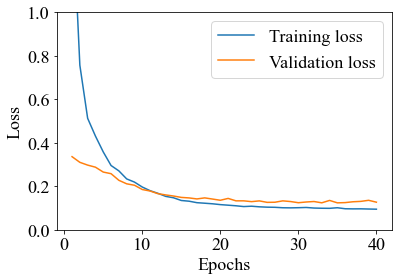

In [126]:
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.ylim(0,1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

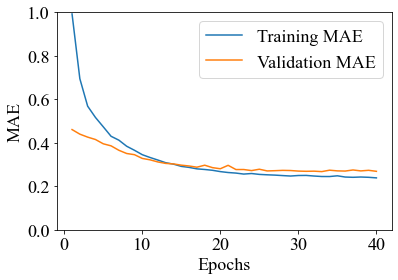

In [127]:
plt.plot(epochs, MAE, label='Training MAE')
plt.plot(epochs, val_MAE, label='Validation MAE')
plt.ylim(0,1)
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [128]:
y_pred_nn_train = nn_model_complex.predict([X_train["most_memorable_characteristics"], X_train[other_cols]], verbose=False).reshape(-1)
y_pred_nn = nn_model_complex.predict([X_test["most_memorable_characteristics"], X_test[other_cols]], verbose=False).reshape(-1)

In [129]:
print_scores(y_pred_nn_train, y_pred_nn)

MSE:		 Train: 0.0942 	Test: 0.1084
MdAE:		 Train: 0.2036 	Test: 0.2143
Accuracy:	 Train: 0.3285 	Test: 0.3393


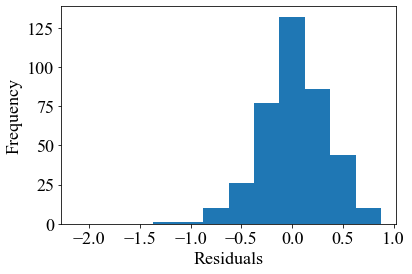

In [130]:
histogram_residuals(y_test, y_pred_nn, "text_embedding")

### Hyperparameter tuning

In [131]:
from keras_tuner import BayesianOptimization
from tensorflow.keras.optimizers import Adam

In [132]:
def build_model(hp):
    # flavors
    model_url1 = "https://tfhub.dev/google/Wiki-words-250-with-normalization/2"
    model_url2 = "https://tfhub.dev/google/nnlm-en-dim50-with-normalization/2"
    flavors_input = layers.Input(shape=(), dtype="string", name="input_flavors")
    flavors_embedding = KerasLayer(
        hp.Choice("embedding_model", values=[model_url1, model_url2]),
        input_shape=[],
        dtype=string,
        trainable=False,
        name="embedding",
    )(flavors_input)
    flavors_dense = layers.Dense(
        units=hp.Choice("units_flavors", values=[8, 16, 32, 64], default=32),
        activation="relu",
        name="dense_flavors",
    )(flavors_embedding)

    # other features
    other_input = layers.Input(shape=(num_other_features,), name="input_other")
    other_dense = layers.Dense(
        hp.Choice("units_other", values=[4, 6, 8, 10], default=8),
        activation="relu",
        name="dense_other",
    )(other_input)
    other_dropout = layers.Dropout(
        hp.Float("dropout", 0.1, 0.4, step=0.05, default=0.3), name="dropout"
    )(other_dense)

    # Merge all features into a single large vector via concatenation
    x = layers.concatenate([flavors_dense, other_dropout], name="concat")

    output = layers.Dense(1, name="dense_output")(x)

    # Instantiate the model
    nn_model_complex = Model(
        inputs=[flavors_input, other_input],
        outputs=[output],
    )

    nn_model_complex.compile(
        optimizer=Adam(
            learning_rate=hp.Choice("learning_rate", values=[1e-3, 5e-4, 1e-4])
        ),
        loss=losses.MeanSquaredError(),
        metrics=[metrics.MeanAbsoluteError(name="MAE")],
    )

    return nn_model_complex

In [133]:
tuner = BayesianOptimization(
    build_model,
    objective="val_loss",
    max_trials=30,
    num_initial_points=5,
    directory="kt_dir",
    project_name="kt_bayes",
)

INFO:tensorflow:Reloading Oracle from existing project kt_dir\kt_bayes\oracle.json


INFO:tensorflow:Reloading Oracle from existing project kt_dir\kt_bayes\oracle.json


INFO:tensorflow:Reloading Tuner from kt_dir\kt_bayes\tuner0.json


INFO:tensorflow:Reloading Tuner from kt_dir\kt_bayes\tuner0.json


In [134]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
embedding_model (Choice)
{'default': 'https://tfhub.dev/google/Wiki-words-250-with-normalization/2', 'conditions': [], 'values': ['https://tfhub.dev/google/Wiki-words-250-with-normalization/2', 'https://tfhub.dev/google/nnlm-en-dim50-with-normalization/2'], 'ordered': False}
units_flavors (Choice)
{'default': 32, 'conditions': [], 'values': [8, 16, 32, 64], 'ordered': True}
units_other (Choice)
{'default': 8, 'conditions': [], 'values': [4, 6, 8, 10], 'ordered': True}
dropout (Float)
{'default': 0.3, 'conditions': [], 'min_value': 0.1, 'max_value': 0.4, 'step': 0.05, 'sampling': None}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0005, 0.0001], 'ordered': True}


In [135]:
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

In [136]:
tuner.search(
    [X_train["most_memorable_characteristics"], X_train[other_cols]],
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(
        [X_val["most_memorable_characteristics"], X_val[other_cols]],
        y_val,
    ),
    callbacks=[early_stopping],
    verbose=2,
)

Trial 30 Complete [00h 08m 33s]
val_loss: 0.1285906285047531

Best val_loss So Far: 0.1157710924744606
Total elapsed time: 00h 17m 52s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [137]:
tuner.results_summary()

Results summary
Results in kt_dir\kt_bayes
Showing 10 best trials
Trial summary
Hyperparameters:
embedding_model: https://tfhub.dev/google/Wiki-words-250-with-normalization/2
units_flavors: 64
units_other: 10
dropout: 0.1
learning_rate: 0.001
Score: 0.1157710924744606
Trial summary
Hyperparameters:
embedding_model: https://tfhub.dev/google/Wiki-words-250-with-normalization/2
units_flavors: 8
units_other: 10
dropout: 0.20000000000000004
learning_rate: 0.001
Score: 0.11722584068775177
Trial summary
Hyperparameters:
embedding_model: https://tfhub.dev/google/Wiki-words-250-with-normalization/2
units_flavors: 64
units_other: 10
dropout: 0.25000000000000006
learning_rate: 0.001
Score: 0.1196509525179863
Trial summary
Hyperparameters:
embedding_model: https://tfhub.dev/google/Wiki-words-250-with-normalization/2
units_flavors: 16
units_other: 10
dropout: 0.15000000000000002
learning_rate: 0.001
Score: 0.12014498561620712
Trial summary
Hyperparameters:
embedding_model: https://tfhub.dev/google/

In [138]:
best_hps = tuner.get_best_hyperparameters()[0]
print(best_hps.values)

{'embedding_model': 'https://tfhub.dev/google/Wiki-words-250-with-normalization/2', 'units_flavors': 64, 'units_other': 10, 'dropout': 0.1, 'learning_rate': 0.001}


In [139]:
h_model = tuner.hypermodel.build(best_hps)
fitted = h_model.fit(
    [X_train["most_memorable_characteristics"], X_train[other_cols]],
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(
        [X_val["most_memorable_characteristics"], X_val[other_cols]],
        y_val,
    ),
    callbacks=[early_stopping],
    verbose=2,
)

Epoch 1/100
59/59 - 1s - loss: 1.5453 - MAE: 0.9800 - val_loss: 0.5486 - val_MAE: 0.6090 - 1s/epoch - 21ms/step
Epoch 2/100
59/59 - 0s - loss: 0.5769 - MAE: 0.6129 - val_loss: 0.3873 - val_MAE: 0.5006 - 427ms/epoch - 7ms/step
Epoch 3/100
59/59 - 0s - loss: 0.4010 - MAE: 0.5037 - val_loss: 0.2888 - val_MAE: 0.4270 - 400ms/epoch - 7ms/step
Epoch 4/100
59/59 - 0s - loss: 0.3302 - MAE: 0.4509 - val_loss: 0.2352 - val_MAE: 0.3837 - 445ms/epoch - 8ms/step
Epoch 5/100
59/59 - 0s - loss: 0.3018 - MAE: 0.4317 - val_loss: 0.2055 - val_MAE: 0.3571 - 433ms/epoch - 7ms/step
Epoch 6/100
59/59 - 0s - loss: 0.2698 - MAE: 0.4077 - val_loss: 0.1965 - val_MAE: 0.3466 - 426ms/epoch - 7ms/step
Epoch 7/100
59/59 - 0s - loss: 0.2468 - MAE: 0.3871 - val_loss: 0.1776 - val_MAE: 0.3291 - 436ms/epoch - 7ms/step
Epoch 8/100
59/59 - 0s - loss: 0.2333 - MAE: 0.3811 - val_loss: 0.1696 - val_MAE: 0.3205 - 391ms/epoch - 7ms/step
Epoch 9/100
59/59 - 0s - loss: 0.2220 - MAE: 0.3742 - val_loss: 0.1591 - val_MAE: 0.3095 -

In [140]:
MAE = fitted.history['MAE']
val_MAE = fitted.history['val_MAE']
loss = fitted.history['loss']
val_loss = fitted.history['val_loss']

epochs = range(1, len(MAE) + 1)

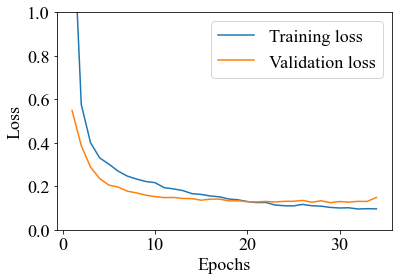

In [141]:
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.ylim(0,1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

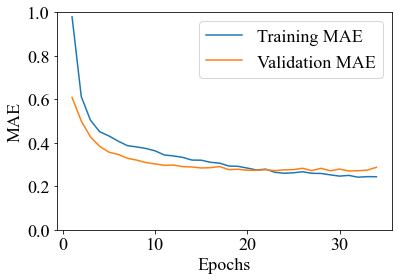

In [142]:
plt.plot(epochs, MAE, label='Training MAE')
plt.plot(epochs, val_MAE, label='Validation MAE')
plt.ylim(0,1)
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [143]:
y_pred_nn_train = h_model.predict([X_train["most_memorable_characteristics"], X_train[other_cols]], verbose=False).reshape(-1)
y_pred_nn = h_model.predict([X_test["most_memorable_characteristics"], X_test[other_cols]], verbose=False).reshape(-1)

In [144]:
print_scores(y_pred_nn_train, y_pred_nn)

MSE:		 Train: 0.0922 	Test: 0.1095
MdAE:		 Train: 0.1972 	Test: 0.2106
Accuracy:	 Train: 0.3312 	Test: 0.3059


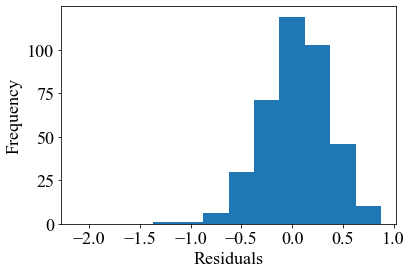

In [145]:
histogram_residuals(y_test, y_pred_nn, "text_embedding")

In [234]:
print_scores(y_pred_ensemble_train, y_pred_ensemble)

MSE:		 Train: 0.0760 	Test: 0.1014
MdAE:		 Train: 0.1716 	Test: 0.2067
Accuracy:	 Train: 0.3660 	Test: 0.3111


# Results

In [212]:
test_mse = {
    "Simple Median Model": 0.1992,
    "Baseline Regression Model": 0.1876,
    "Linear Regression with all features": 0.1257,
    "Backward elimination": 0.1261,
    "LASSO": 0.1283,
    "Random Forest with flavors": 0.1511,
    "Random Forest without flavors": 0.1727,
    "Neural network, text embedding only": 0.1091,
    "Neural network with two input layers": 0.1095,
}

test_mdae = {
    "Simple Median Model": 0.2500,
    "Baseline Regression Model": 0.2929,
    "Linear Regression with all features": 0.2138,
    "Backward elimination": 0.2137,
    "LASSO": 0.2241,
    "Random Forest with flavors": 0.2544,
    "Random Forest without flavors": 0.2664,
    "Neural network, text embedding only": 0.2121,
    "Neural network with two input layers": 0.2106,
}

test_acc = {
    "Simple Median Model": 0.1825,
    "Baseline Regression Model": 0.2134,
    "Linear Regression with all features": 0.3316,
    "Backward elimination": 0.3111,
    "LASSO": 0.2905,
    "Random Forest with flavors": 0.2468,
    "Random Forest without flavors": 0.2416,
    "Neural network, text embedding only": 0.3342,
    "Neural network with two input layers": 0.3059,
}

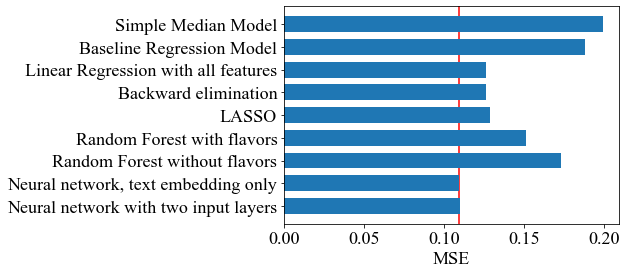

In [214]:
y_pos = np.arange(len(test_mse))
fig, ax = plt.subplots(figsize=(6,4))
plt.barh(y_pos, test_mse.values(), height=0.7, zorder=2)
plt.xlabel("MSE")
ax.set_yticks(y_pos, labels=test_mse.keys())
ax.invert_yaxis()  # labels read top-to-bottom
ax.axvline(min(test_mse.values()), c="red", zorder=1)
plt.savefig("figures/MSE_summarized.pdf", bbox_inches="tight")
plt.show()

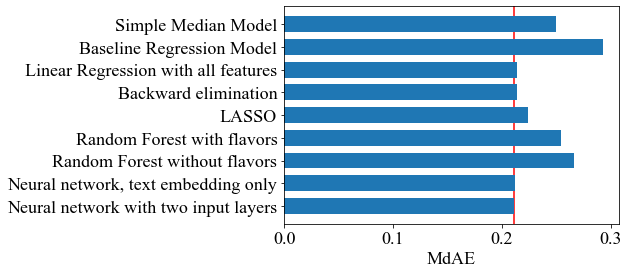

In [215]:
y_pos = np.arange(len(test_mdae))
fig, ax = plt.subplots(figsize=(6,4))
plt.barh(y_pos, test_mdae.values(), height=0.7, zorder=2)
plt.xlabel("MdAE")
ax.set_yticks(y_pos, labels=test_mdae.keys())
ax.invert_yaxis()  # labels read top-to-bottom
ax.axvline(min(test_mdae.values()), c="red", zorder=1)
plt.savefig("figures/MdAE_summarized.pdf", bbox_inches="tight")
plt.show()

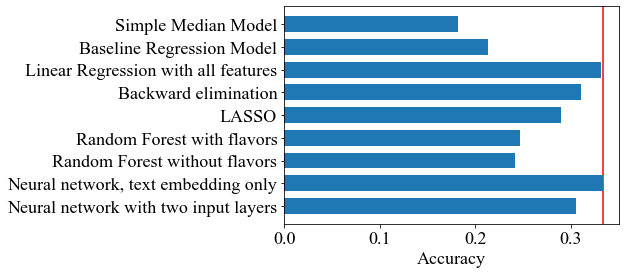

In [216]:
y_pos = np.arange(len(test_acc))
fig, ax = plt.subplots(figsize=(6,4))
plt.barh(y_pos, test_acc.values(), height=0.7, zorder=2)
plt.xlabel("Accuracy")
ax.set_yticks(y_pos, labels=test_acc.keys())
ax.invert_yaxis()  # labels read top-to-bottom
ax.axvline(max(test_acc.values()), c="red", zorder=1)
plt.savefig("figures/Acc_summarized.pdf", bbox_inches="tight")
plt.show()